In [10]:
# =================================================================================
# SECTION 1: INVENTORY CLASSIFICATION ANALYSIS
# Complete ABC, FSN, ADI, and CV Classification System
# =================================================================================

import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load the data
print("="*80)
print("SECTION 1: INVENTORY CLASSIFICATION ANALYSIS")
print("ABC | FSN | ADI | CV Classification")
print("="*80)

# Load from CSV file
data = "/content/drive/MyDrive/Data/supermarket.csv"
df = pd.read_csv(data)

# Convert Order Date to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')

print(f"\n✓ Data loaded successfully")
print(f"  Total records: {len(df)}")
print(f"  Unique products: {df['Product ID'].nunique()}")
print(f"  Date range: {df['Order Date'].min().strftime('%Y-%m-%d')} to {df['Order Date'].max().strftime('%Y-%m-%d')}")

# =================================================================================
# STEP 1: AGGREGATE DATA BY PRODUCT
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 1: Product Aggregation")
print(f"{'-'*80}")

product_agg = df.groupby('Product ID').agg({
    'Product Name': 'first',
    'Category': 'first',
    'Sub-Category': 'first',
    'Sales': ['sum', 'count', 'mean', 'std'],
    'Order Date': lambda x: (x.max() - x.min()).days
}).reset_index()

product_agg.columns = ['Product_ID', 'Product_Name', 'Category', 'Sub_Category',
                        'Total_Sales', 'Order_Count', 'Avg_Sales', 'Std_Sales', 'Date_Range_Days']

# Calculate additional metrics
product_agg['Quantity'] = product_agg['Order_Count']  # Using order count as proxy for quantity
product_agg['Unit_Cost'] = product_agg['Total_Sales'] / product_agg['Quantity']

print(f"✓ Aggregated {len(product_agg)} unique products")

# =================================================================================
# STEP 2: ABC CLASSIFICATION (Criticality Analysis)
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 2: ABC Classification (Criticality - Dollar Usage)")
print(f"{'-'*80}")

# Calculate dollar usage
product_agg['Dollar_Usage'] = product_agg['Total_Sales']
product_agg = product_agg.sort_values('Dollar_Usage', ascending=False).reset_index(drop=True)

# Calculate percentages
total_dollar_usage = product_agg['Dollar_Usage'].sum()
total_quantity = product_agg['Quantity'].sum()

product_agg['Pct_Cost'] = (product_agg['Dollar_Usage'] / total_dollar_usage) * 100
product_agg['Pct_Quantity'] = (product_agg['Quantity'] / total_quantity) * 100
product_agg['Cum_Pct_Cost'] = product_agg['Pct_Cost'].cumsum()
product_agg['Cum_Pct_Quantity'] = product_agg['Pct_Quantity'].cumsum()

# ABC Classification logic
def classify_abc(cum_pct):
    if cum_pct <= 70:
        return 'A'
    elif cum_pct <= 90:
        return 'B'
    else:
        return 'C'

product_agg['ABC_Class'] = product_agg['Cum_Pct_Cost'].apply(classify_abc)

# Summary
abc_summary = product_agg.groupby('ABC_Class').agg({
    'Product_ID': 'count',
    'Pct_Cost': 'sum',
    'Pct_Quantity': 'sum'
}).round(2)

print(f"\n ABC Classification Summary:")
print(f" {abc_summary}")
print(f"\n ✓ Class A: {len(product_agg[product_agg['ABC_Class']=='A'])} products (High Value)")
print(f" ✓ Class B: {len(product_agg[product_agg['ABC_Class']=='B'])} products (Medium Value)")
print(f" ✓ Class C: {len(product_agg[product_agg['ABC_Class']=='C'])} products (Low Value)")

# =================================================================================
# STEP 3: FSN CLASSIFICATION (Velocity Analysis)
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 3: FSN Classification (Fast/Slow/Non-Moving)")
print(f"{'-'*80}")

# Calculate total demand (using quantity as demand)
product_agg['Total_Demand'] = product_agg['Quantity']

# Sort by demand for FSN
fsn_sorted = product_agg.sort_values('Total_Demand', ascending=True).reset_index(drop=True)

# Calculate quartiles
n = len(fsn_sorted)
Q1 = fsn_sorted['Total_Demand'].quantile(0.25)
Q3 = fsn_sorted['Total_Demand'].quantile(0.75)

print(f"\n FSN Quartiles:")
print(f"  Q1 (25th percentile): {Q1:.2f}")
print(f"  Q3 (75th percentile): {Q3:.2f}")

# FSN Classification logic
def classify_fsn(demand, q1, q3):
    if demand > q3:
        return 'F'  # Fast Moving
    elif demand < q1:
        return 'N'  # Non-Moving
    else:
        return 'S'  # Slow Moving

product_agg['FSN_Class'] = product_agg['Total_Demand'].apply(
    lambda x: classify_fsn(x, Q1, Q3)
)

# Summary
fsn_summary = product_agg.groupby('FSN_Class').agg({
    'Product_ID': 'count',
    'Total_Demand': ['min', 'max', 'mean']
}).round(2)

print(f"\n FSN Classification Summary:")
print(f" {fsn_summary}")
print(f"\n ✓ Class F (Fast): {len(product_agg[product_agg['FSN_Class']=='F'])} products")
print(f" ✓ Class S (Slow): {len(product_agg[product_agg['FSN_Class']=='S'])} products")
print(f" ✓ Class N (Non-Moving): {len(product_agg[product_agg['FSN_Class']=='N'])} products")

# =================================================================================
# STEP 4: ADI CALCULATION (Average Demand Interval)
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 4: ADI Calculation (Average Demand Interval)")
print(f"{'-'*80}")

# ADI = Number of periods / Total periods with non-zero demand
# Calculate periods with demand (transactions) vs total available periods
# Assuming daily periods in the date range

def calculate_adi(row):
    """
    ADI = Total periods / Number of periods with demand
    Using days as periods
    """
    total_periods = row['Date_Range_Days'] + 1  # +1 to include both start and end date
    periods_with_demand = row['Order_Count']

    if periods_with_demand == 0 or total_periods == 0:
        return 0

    adi = total_periods / periods_with_demand
    return adi

product_agg['ADI'] = product_agg.apply(calculate_adi, axis=1)

# Handle edge cases
product_agg['ADI'] = product_agg['ADI'].replace([np.inf, -np.inf], 0)
product_agg['ADI'] = product_agg['ADI'].fillna(0)

print(f"\n ADI Statistics:")
print(f"  Mean ADI: {product_agg['ADI'].mean():.2f}")
print(f"  Median ADI: {product_agg['ADI'].median():.2f}")
print(f"  Min ADI: {product_agg['ADI'].min():.2f}")
print(f"  Max ADI: {product_agg['ADI'].max():.2f}")
print(f"\n  Interpretation:")
print(f"    ADI > 1.32: Intermittent/Lumpy demand")
print(f"    ADI <= 1.32: Smooth/Erratic demand")

# =================================================================================
# STEP 5: CV CALCULATION (Coefficient of Variation)
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 5: CV Calculation (Coefficient of Variation)")
print(f"{'-'*80}")

# CV = Standard Deviation of Demand / Mean Demand
# Using Sales as proxy for demand
product_agg['CV_Squared'] = (product_agg['Std_Sales'] / product_agg['Avg_Sales']) ** 2

# Handle cases where Avg_Sales is 0 or Std is NaN
product_agg['CV_Squared'] = product_agg['CV_Squared'].replace([np.inf, -np.inf], 0)
product_agg['CV_Squared'] = product_agg['CV_Squared'].fillna(0)

print(f"\n CV²Statistics:")
print(f"  Mean CV²: {product_agg['CV_Squared'].mean():.2f}")
print(f"  Median CV²: {product_agg['CV_Squared'].median():.2f}")
print(f"  Min CV²: {product_agg['CV_Squared'].min():.2f}")
print(f"  Max CV²: {product_agg['CV_Squared'].max():.2f}")
print(f"\n  Interpretation:")
print(f"    CV² > 0.49: High variability (Erratic/Lumpy)")
print(f"    CV² <= 0.49: Low variability (Smooth/Intermittent)")

# =================================================================================
# STEP 6: DEMAND PATTERN CLASSIFICATION (ADI-CV Matrix)
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 6: Demand Pattern Classification (ADI-CV Matrix)")
print(f"{'-'*80}")

# Classification based on ADI and CV² thresholds:
# ADI > 1.32 & CV² > 0.49  → Lumpy
# ADI > 1.32 & CV² <= 0.49 → Intermittent
# ADI <= 1.32 & CV² > 0.49 → Erratic
# ADI <= 1.32 & CV² <= 0.49 → Smooth

def classify_demand_pattern(row):
    adi = row['ADI']
    cv_sq = row['CV_Squared']

    if adi > 1.32 and cv_sq > 0.49:
        return 'Lumpy'
    elif adi > 1.32 and cv_sq <= 0.49:
        return 'Intermittent'
    elif adi <= 1.32 and cv_sq > 0.49:
        return 'Erratic'
    else:  # adi <= 1.32 and cv_sq <= 0.49
        return 'Smooth'

product_agg['Demand_Pattern'] = product_agg.apply(classify_demand_pattern, axis=1)

# Summary
pattern_summary = product_agg['Demand_Pattern'].value_counts()
print(f"\n Demand Pattern Classification Summary:")
for pattern, count in pattern_summary.items():
    pct = (count / len(product_agg)) * 100
    print(f"  {pattern}: {count} products ({pct:.1f}%)")

print(f"\n Pattern Descriptions:")
print(f"  • Smooth: Regular, predictable demand (ADI≤1.32, CV²≤0.49)")
print(f"  • Erratic: Frequent but variable demand (ADI≤1.32, CV²>0.49)")
print(f"  • Intermittent: Infrequent, stable demand (ADI>1.32, CV²≤0.49)")
print(f"  • Lumpy: Infrequent, highly variable demand (ADI>1.32, CV²>0.49)")

# =================================================================================
# STEP 7: COMBINED CLASSIFICATION WITH RECOMMENDATIONS
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 7: Combined Classification Matrix with Recommendations")
print(f"{'-'*80}")

# Create combined classification: ABC-FSN-DemandPattern
product_agg['Combined_Class'] = (
    product_agg['ABC_Class'] + '-' +
    product_agg['FSN_Class'] + '-' +
    product_agg['Demand_Pattern']
)

# =================================================================================
# SERVICE LEVEL RECOMMENDATIONS BASED ON ABC CLASSIFICATION
# =================================================================================
def assign_service_level(abc_class):
    """
    Assign target service level based on ABC classification
    Higher value items (A) require higher service levels
    """
    service_levels = {
        'A': 99.0,  # 99% service level for critical items
        'B': 95.0,  # 95% service level for moderate items
        'C': 90.0   # 90% service level for low-value items
    }
    return service_levels[abc_class]

product_agg['Service_Level'] = product_agg['ABC_Class'].apply(assign_service_level)

# Z-score lookup table for service levels (for normal distribution)
z_scores = {
    99.0: 2.33,  # 99% service level
    95.0: 1.65,  # 95% service level
    90.0: 1.28   # 90% service level
}

product_agg['Z_Score'] = product_agg['Service_Level'].map(z_scores)

# =================================================================================
# FSN-BASED INVENTORY STRATEGY RECOMMENDATIONS
# =================================================================================
def get_fsn_strategy(fsn_class):
    """
    Inventory strategy based on FSN classification
    """
    strategies = {
        'F': {
            'strategy': 'Frequent Reorder',
            'review_frequency': 'Daily/Weekly',
            'stock_policy': 'Maintain high stock levels',
            'order_frequency': 'Frequent small orders',
            'priority': 'High'
        },
        'S': {
            'strategy': 'Periodic Review',
            'review_frequency': 'Weekly/Monthly',
            'stock_policy': 'Moderate stock levels',
            'order_frequency': 'Regular scheduled orders',
            'priority': 'Medium'
        },
        'N': {
            'strategy': 'Order on Demand',
            'review_frequency': 'Quarterly/Annually',
            'stock_policy': 'Minimal or zero stock',
            'order_frequency': 'Order when requested',
            'priority': 'Low'
        }
    }
    return strategies[fsn_class]

# Apply FSN strategies
for key in ['strategy', 'review_frequency', 'stock_policy', 'order_frequency', 'priority']:
    product_agg[f'FSN_{key}'] = product_agg['FSN_Class'].apply(
        lambda x: get_fsn_strategy(x)[key]
    )

# =================================================================================
# COMBINED ABC-FSN STRATEGIC RECOMMENDATIONS
# =================================================================================
def get_combined_recommendation(row):
    """
    Comprehensive inventory management recommendation
    Based on ABC (criticality), FSN (velocity), and Demand Pattern
    """
    abc = row['ABC_Class']
    fsn = row['FSN_Class']
    pattern = row['Demand_Pattern']

    # High Value (A) Products
    if abc == 'A':
        if fsn == 'F':
            if pattern == 'Smooth':
                return {
                    'category': 'CRITICAL - STABLE',
                    'recommendation': 'Implement continuous replenishment with VMI (Vendor Managed Inventory)',
                    'safety_stock': 'High (30-45 days)',
                    'reorder_method': 'Automated min-max system',
                    'monitoring': 'Daily tracking with alerts'
                }
            else:  # Erratic
                return {
                    'category': 'CRITICAL - VARIABLE',
                    'recommendation': 'Maintain substantial safety stock with dynamic reorder points',
                    'safety_stock': 'Very High (45-60 days)',
                    'reorder_method': 'Statistical safety stock calculation',
                    'monitoring': 'Real-time monitoring required'
                }
        elif fsn == 'S':
            return {
                'category': 'HIGH VALUE - SLOW',
                'recommendation': 'Reduce stock levels but ensure availability through supplier partnerships',
                'safety_stock': 'Moderate (15-30 days)',
                'reorder_method': 'Periodic review with lead time buffer',
                'monitoring': 'Weekly review'
            }
        else:  # N
            return {
                'category': 'HIGH VALUE - NON-MOVING',
                'recommendation': 'Evaluate for phase-out or move to make-to-order',
                'safety_stock': 'Minimal (0-7 days)',
                'reorder_method': 'Order on customer demand',
                'monitoring': 'Monthly review for obsolescence'
            }

    # Medium Value (B) Products
    elif abc == 'B':
        if fsn == 'F':
            return {
                'category': 'STANDARD - FAST',
                'recommendation': 'Regular reorder with economic order quantity (EOQ) optimization',
                'safety_stock': 'Moderate (20-30 days)',
                'reorder_method': 'Fixed order quantity with reorder point',
                'monitoring': 'Weekly monitoring'
            }
        elif fsn == 'S':
            return {
                'category': 'STANDARD - SLOW',
                'recommendation': 'Periodic review system with flexible order quantities',
                'safety_stock': 'Low-Moderate (10-20 days)',
                'reorder_method': 'Periodic review (monthly)',
                'monitoring': 'Bi-weekly review'
            }
        else:  # N
            return {
                'category': 'MEDIUM VALUE - NON-MOVING',
                'recommendation': 'Consider discontinuation or clearance sale',
                'safety_stock': 'Zero',
                'reorder_method': 'No automatic reorder',
                'monitoring': 'Quarterly review'
            }

    # Low Value (C) Products
    else:
        if fsn == 'F':
            return {
                'category': 'LOW VALUE - FAST',
                'recommendation': 'Bulk ordering with generous safety stock (low holding cost)',
                'safety_stock': 'High (60-90 days)',
                'reorder_method': 'Large lot sizes, infrequent orders',
                'monitoring': 'Monthly monitoring'
            }
        elif fsn == 'S':
            return {
                'category': 'LOW VALUE - SLOW',
                'recommendation': 'Minimal stock with basic reorder system',
                'safety_stock': 'Low (7-15 days)',
                'reorder_method': 'Two-bin system',
                'monitoring': 'Monthly spot checks'
            }
        else:  # N
            return {
                'category': 'LOW VALUE - NON-MOVING',
                'recommendation': 'Immediate phase-out or liquidation',
                'safety_stock': 'Zero',
                'reorder_method': 'No reorder',
                'monitoring': 'Annual review for removal'
            }

# Apply comprehensive recommendations
recommendations = product_agg.apply(get_combined_recommendation, axis=1)

product_agg['Recommendation_Category'] = recommendations.apply(lambda x: x['category'])
product_agg['Recommendation'] = recommendations.apply(lambda x: x['recommendation'])
product_agg['Safety_Stock_Days'] = recommendations.apply(lambda x: x['safety_stock'])
product_agg['Reorder_Method'] = recommendations.apply(lambda x: x['reorder_method'])
product_agg['Monitoring_Frequency'] = recommendations.apply(lambda x: x['monitoring'])

# Strategic recommendation based on classification
def get_strategy(row):
    abc = row['ABC_Class']
    fsn = row['FSN_Class']
    pattern = row['Demand_Pattern']

    # High value (A) products
    if abc == 'A':
        if fsn == 'F' and pattern == 'Smooth':
            return 'CRITICAL: Continuous Replenishment - High Priority'
        elif fsn == 'F' and pattern == 'Erratic':
            return 'CRITICAL: Safety Stock Required - High Variability'
        elif pattern == 'Lumpy':
            return 'MONITOR: Forecast Carefully - Irregular High Value Demand'
        elif fsn in ['S', 'N']:
            return 'REVIEW: High Value but Slow - Optimize Stock Levels'
        else:
            return 'STRATEGIC: Maintain Service Level - Important Item'

    # Medium value (B) products
    elif abc == 'B':
        if pattern == 'Smooth':
            return 'STANDARD: Regular Reorder - Predictable Demand'
        elif pattern == 'Erratic':
            return 'BUFFER STOCK: Moderate Safety Stock Required'
        elif pattern == 'Intermittent':
            return 'PERIODIC REVIEW: Monitor and Order as Needed'
        else:  # Lumpy
            return 'FLEXIBLE: Adjust Order Quantity Based on Forecast'

    # Low value (C) products
    else:  # C
        if fsn == 'F':
            return 'OPTIMIZE: Bulk Ordering - High Volume Low Value'
        elif fsn == 'N':
            return 'PHASE OUT: Consider Discontinuation - Low Priority'
        elif pattern == 'Lumpy':
            return 'MINIMAL STOCK: Order on Demand Only'
        else:
            return 'BASIC: Simple Reorder System - Low Cost Items'

product_agg['Strategy'] = product_agg.apply(get_strategy, axis=1)

# =================================================================================
# FINAL OUTPUT: TOP 10 PRODUCTS
# =================================================================================
print(f"\n{'='*80}")
print("FINAL RESULTS: TOP 10 PRODUCTS BY DOLLAR USAGE")
print(f"{'='*80}\n")

# Select columns for display
output_columns = [
    'Product_ID', 'Product_Name', 'Category', 'Sub_Category',
    'Dollar_Usage', 'Quantity', 'ABC_Class', 'FSN_Class',
    'ADI', 'CV_Squared', 'Demand_Pattern', 'Combined_Class', 'Strategy'
]

top_10 = product_agg[output_columns].head(10).copy()

# Format for better display
top_10['Dollar_Usage'] = top_10['Dollar_Usage'].apply(lambda x: f"${x:,.2f}")
top_10['ADI'] = top_10['ADI'].apply(lambda x: f"{x:.3f}")
top_10['CV_Squared'] = top_10['CV_Squared'].apply(lambda x: f"{x:.3f}")

# Display results
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 40)

print(top_10.to_string(index=False))

# =================================================================================
# SUMMARY STATISTICS
# =================================================================================
print(f"\n{'='*80}")
print("CLASSIFICATION SUMMARY STATISTICS")
print(f"{'='*80}\n")

# ABC-FSN Cross-tabulation
print("ABC-FSN Matrix:")
abc_fsn_matrix = pd.crosstab(product_agg['ABC_Class'], product_agg['FSN_Class'])
print(abc_fsn_matrix)

print(f"\n{'-'*80}\n")

# ABC-DemandPattern Cross-tabulation
print("ABC-Demand Pattern Matrix:")
abc_pattern_matrix = pd.crosstab(product_agg['ABC_Class'], product_agg['Demand_Pattern'])
print(abc_pattern_matrix)

print(f"\n{'-'*80}\n")

# FSN-DemandPattern Cross-tabulation
print("FSN-Demand Pattern Matrix:")
fsn_pattern_matrix = pd.crosstab(product_agg['FSN_Class'], product_agg['Demand_Pattern'])
print(fsn_pattern_matrix)

print(f"\n{'-'*80}\n")

# =================================================================================
# SERVICE LEVEL DISTRIBUTION
# =================================================================================
print("SERVICE LEVEL DISTRIBUTION:")
service_level_dist = product_agg.groupby('ABC_Class').agg({
    'Product_ID': 'count',
    'Service_Level': 'first',
    'Dollar_Usage': 'sum'
}).round(2)
service_level_dist.columns = ['Product_Count', 'Service_Level_Target', 'Total_Dollar_Usage']
print(service_level_dist)

print(f"\n{'-'*80}\n")

# =================================================================================
# FSN STRATEGY DISTRIBUTION
# =================================================================================
print("FSN INVENTORY STRATEGY DISTRIBUTION:")
fsn_strategy = product_agg.groupby('FSN_Class').agg({
    'Product_ID': 'count',
    'FSN_strategy': 'first',
    'FSN_priority': 'first'
}).round(2)
fsn_strategy.columns = ['Product_Count', 'Strategy', 'Priority']
print(fsn_strategy)

print(f"\n{'-'*80}\n")

# =================================================================================
# RECOMMENDATION CATEGORY SUMMARY
# =================================================================================
print("RECOMMENDATION CATEGORY SUMMARY:")
rec_summary = product_agg['Recommendation_Category'].value_counts().sort_index()
print("\nProduct Distribution by Recommendation Category:")
for category, count in rec_summary.items():
    pct = (count / len(product_agg)) * 100
    print(f"  {category}: {count} products ({pct:.1f}%)")

print(f"\n{'-'*80}\n")

# =================================================================================
# KEY INSIGHTS & ACTION ITEMS
# =================================================================================
print("KEY INSIGHTS & ACTION ITEMS:")
print(f"\n1. HIGH PRIORITY ITEMS (Class A):")
class_a_count = len(product_agg[product_agg['ABC_Class'] == 'A'])
class_a_value = product_agg[product_agg['ABC_Class'] == 'A']['Dollar_Usage'].sum()
class_a_pct = (class_a_value / product_agg['Dollar_Usage'].sum()) * 100
print(f"   • {class_a_count} products ({class_a_count/len(product_agg)*100:.1f}%)")
print(f"   • ${class_a_value:,.2f} total value ({class_a_pct:.1f}% of total)")
print(f"   • Target Service Level: 99%")
print(f"   • Requires daily monitoring and automated replenishment")

print(f"\n2. FAST MOVING ITEMS (Class F):")
class_f_count = len(product_agg[product_agg['FSN_Class'] == 'F'])
fast_critical = len(product_agg[(product_agg['ABC_Class'] == 'A') & (product_agg['FSN_Class'] == 'F')])
print(f"   • {class_f_count} products ({class_f_count/len(product_agg)*100:.1f}%)")
print(f"   • {fast_critical} are CRITICAL (A-F combination)")
print(f"   • Implement frequent reorder systems")

print(f"\n3. NON-MOVING ITEMS (Class N):")
class_n_count = len(product_agg[product_agg['FSN_Class'] == 'N'])
class_n_value = product_agg[product_agg['FSN_Class'] == 'N']['Dollar_Usage'].sum()
print(f"   • {class_n_count} products ({class_n_count/len(product_agg)*100:.1f}%)")
print(f"   • ${class_n_value:,.2f} tied up in slow inventory")
print(f"   • Review for discontinuation or liquidation")

print(f"\n4. DEMAND PATTERN INSIGHTS:")
lumpy_count = len(product_agg[product_agg['Demand_Pattern'] == 'Lumpy'])
erratic_count = len(product_agg[product_agg['Demand_Pattern'] == 'Erratic'])
print(f"   • {lumpy_count} Lumpy items - Require higher safety stock")
print(f"   • {erratic_count} Erratic items - Need dynamic reorder points")
print(f"   • Focus forecasting efforts on these categories")

print(f"\n{'='*80}")
print("✓ SECTION 1: CLASSIFICATION ANALYSIS COMPLETE")
print(f"{'='*80}")

# Save detailed results to CSV
output_file = 'inventory_classification_detailed.csv'
output_columns_save = [
    'Product_ID', 'Product_Name', 'Category', 'Sub_Category',
    'Dollar_Usage', 'Quantity', 'ABC_Class', 'FSN_Class',
    'Service_Level', 'Z_Score', 'ADI', 'CV_Squared', 'Demand_Pattern',
    'Combined_Class', 'Recommendation_Category', 'Recommendation',
    'Safety_Stock_Days', 'Reorder_Method', 'Monitoring_Frequency',
    'FSN_strategy', 'FSN_priority', 'FSN_review_frequency',
    'FSN_stock_policy', 'FSN_order_frequency'
]
product_agg[output_columns_save].to_csv(output_file, index=False)
print(f"\n✓ Detailed results saved to: {output_file}")

SECTION 1: INVENTORY CLASSIFICATION ANALYSIS
ABC | FSN | ADI | CV Classification

✓ Data loaded successfully
  Total records: 9800
  Unique products: 1861
  Date range: 2015-01-03 to 2018-12-30

--------------------------------------------------------------------------------
STEP 1: Product Aggregation
--------------------------------------------------------------------------------
✓ Aggregated 1861 unique products

--------------------------------------------------------------------------------
STEP 2: ABC Classification (Criticality - Dollar Usage)
--------------------------------------------------------------------------------

 ABC Classification Summary:
            Product_ID  Pct_Cost  Pct_Quantity
ABC_Class                                    
A                 279     69.97         18.58
B                 371     20.02         21.56
C                1211     10.01         59.86

 ✓ Class A: 279 products (High Value)
 ✓ Class B: 371 products (Medium Value)
 ✓ Class C: 1211 produ


DEMAND PATTERN VISUALIZATION

--------------------------------------------------------------------------------
STEP 1: Selecting Sample Products (Min 2 Orders)
--------------------------------------------------------------------------------
✓ Total products with ≥2 orders: 1766
✓ Smooth: 1 products selected
✓ Erratic: 0 products selected
✓ Intermittent: 3 products selected
✓ Lumpy: 3 products selected

--------------------------------------------------------------------------------
STEP 2: Preparing Time Series Data
--------------------------------------------------------------------------------
✓ Time series extraction function ready

--------------------------------------------------------------------------------
STEP 3: Creating Demand Pattern Visualizations
--------------------------------------------------------------------------------

  Creating Smooth pattern graphs...
    ✓ Product 1: Zebra ZM400 Thermal Label Prin

  Creating Erratic pattern graphs...

  Creating Intermitten

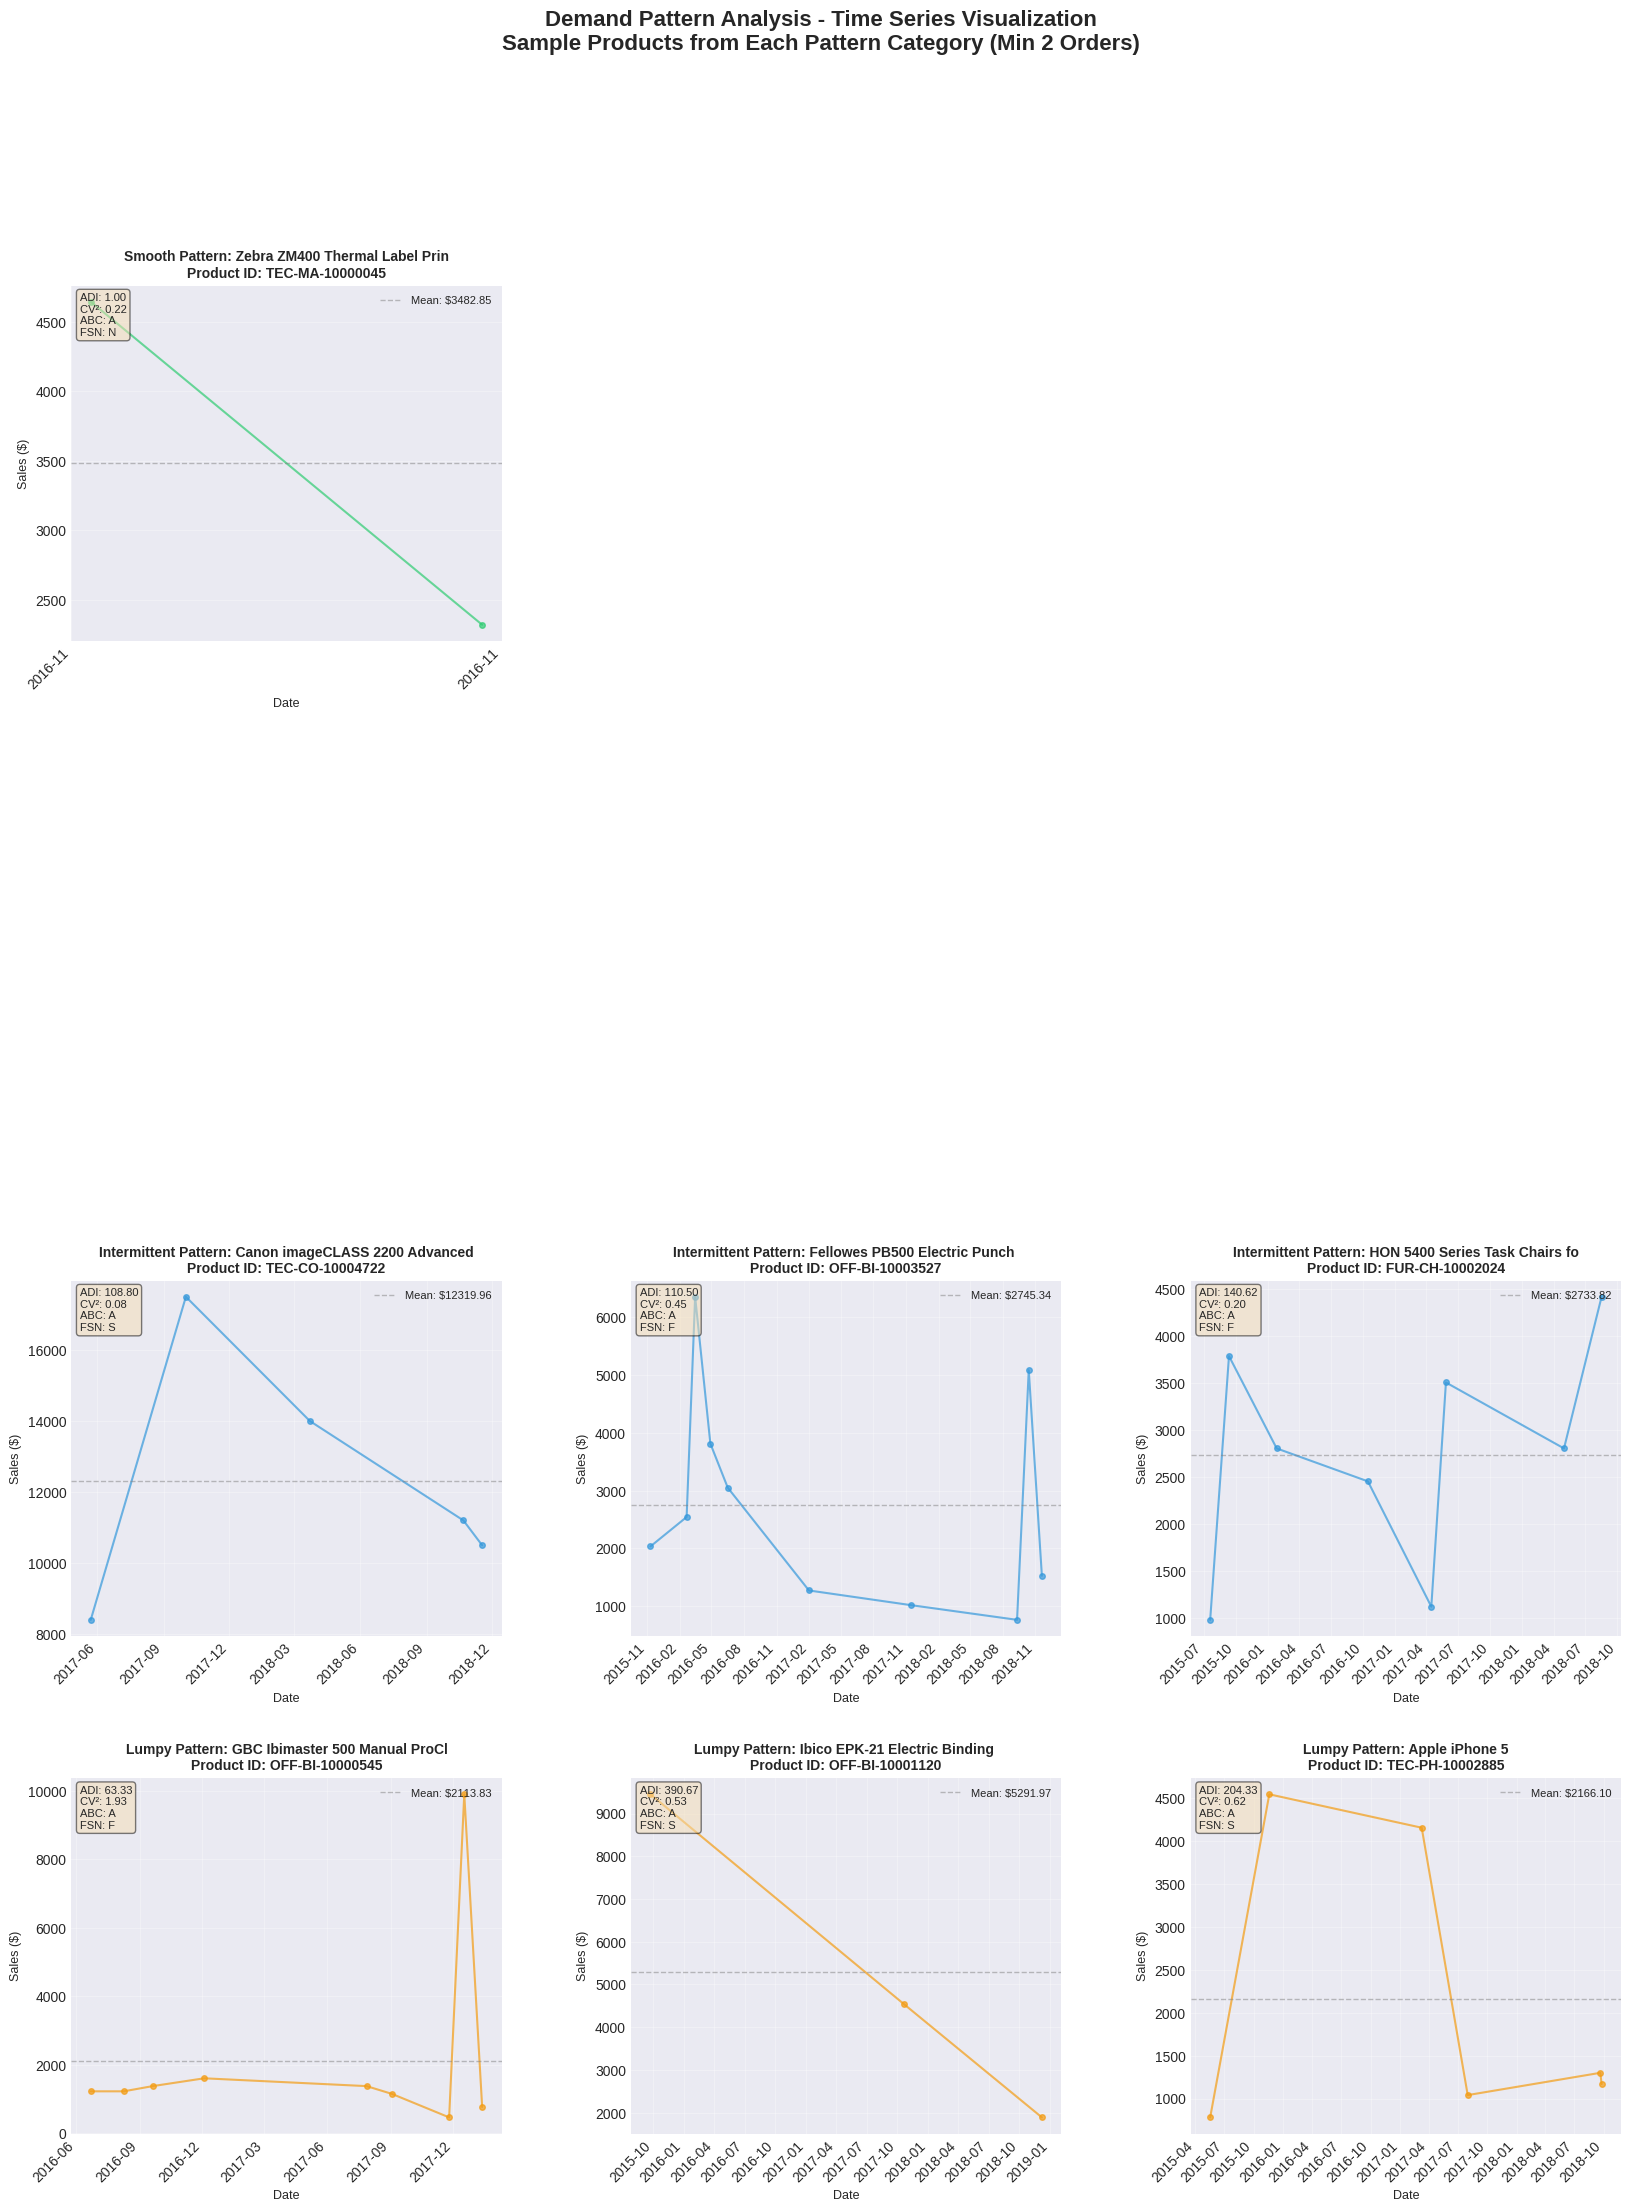


--------------------------------------------------------------------------------
STEP 4: Creating Pattern Comparison Chart
--------------------------------------------------------------------------------
✓ Comparison chart saved as: demand_pattern_comparison.png


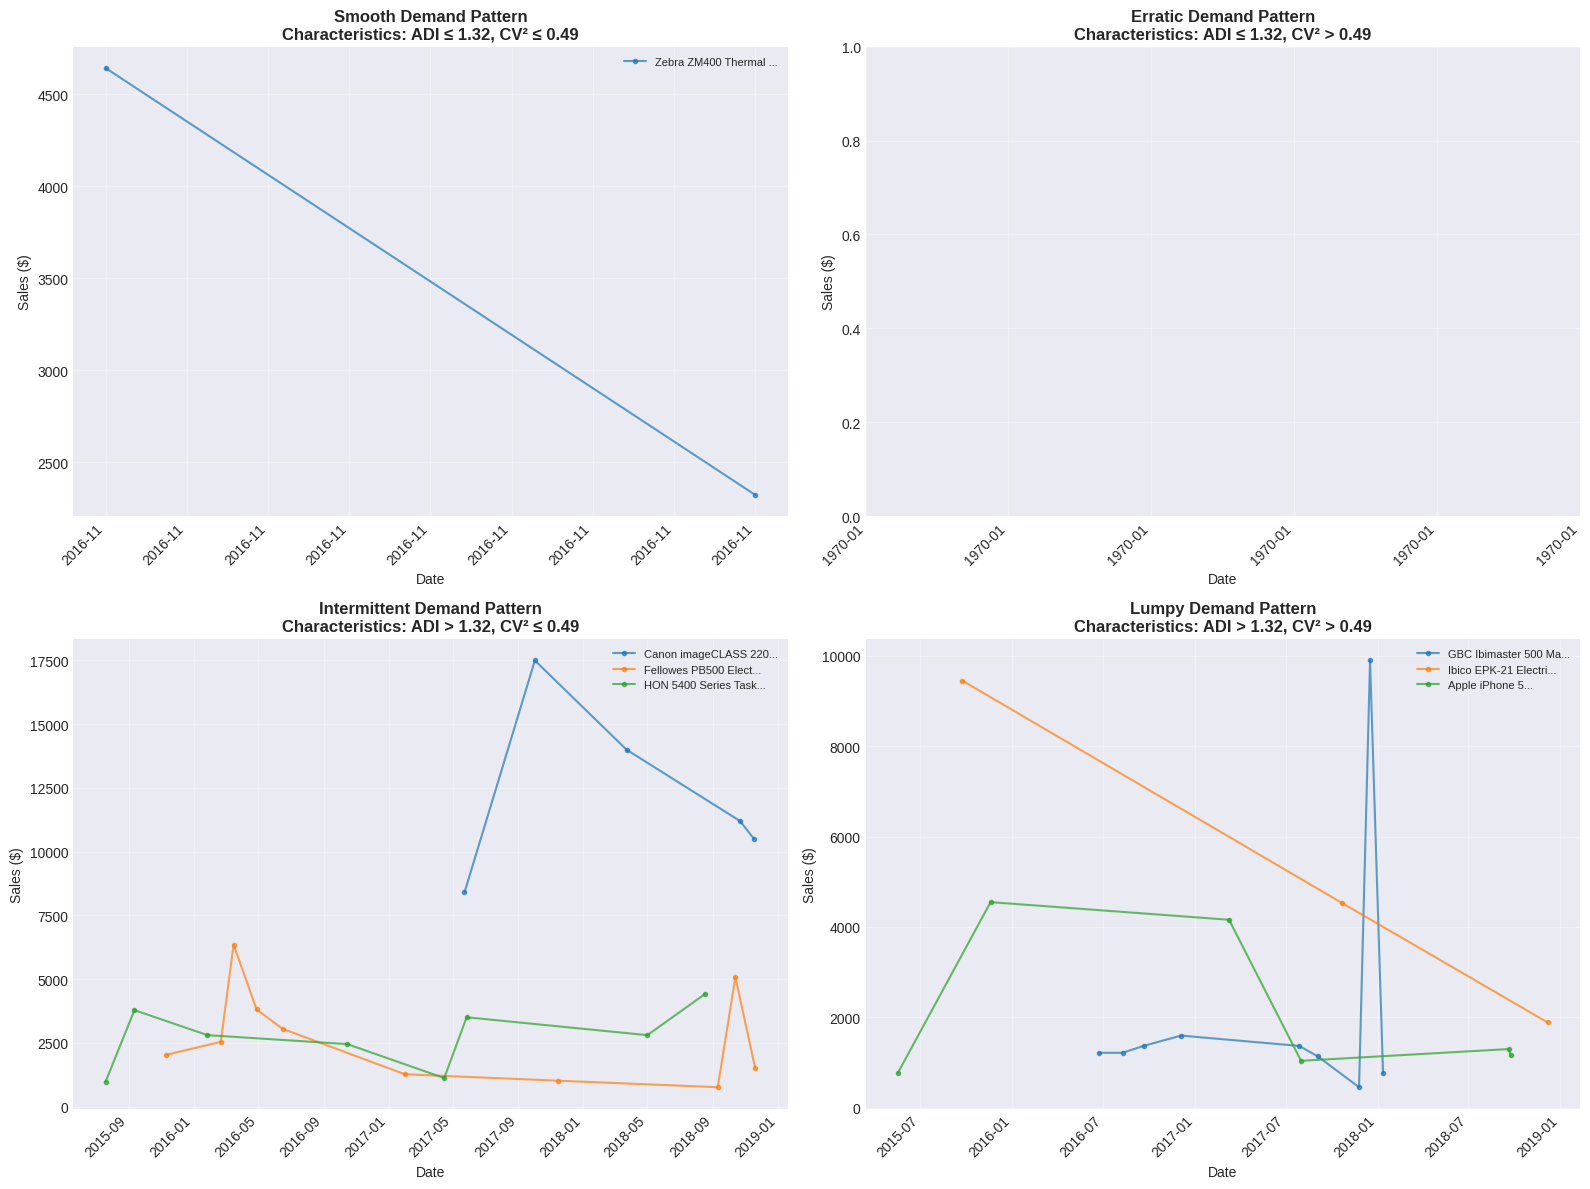


FORECASTING RECOMMENDATIONS FOR EACH DEMAND PATTERN:
For SMOOTH patterns: Since most data points are 1, use expert judgment
For ERRATIC patterns: There is no consistent demand pattern, consider market factors
For LUMPY and INTERMITTENT patterns: Use Croston, SBA, or TSB forecasting for short-term forecasting, and for long-term forecasting, use machine learning regression approach or hybrid methods (classification + regression)

✓ SECTION 2: DEMAND PATTERN VISUALIZATION COMPLETE


In [16]:
# =================================================================================
# SECTION 2: DEMAND PATTERN VISUALIZATION
# Time Series Graphs for Each Demand Pattern Type
# =================================================================================

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec

print("\n" + "="*80)
print("DEMAND PATTERN VISUALIZATION")
print("="*80)

# =================================================================================
# STEP 1: SELECT SAMPLE PRODUCTS (MINIMUM 2 ORDERS)
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 1: Selecting Sample Products (Min 2 Orders)")
print(f"{'-'*80}")

# Filter products with at least 2 orders
product_agg_filtered = product_agg[product_agg['Order_Count'] >= 2].copy()

print(f"✓ Total products with ≥2 orders: {len(product_agg_filtered)}")

# Select 3 representative products from each demand pattern
sample_products = {}
for pattern in ['Smooth', 'Erratic', 'Intermittent', 'Lumpy']:
    pattern_products = product_agg_filtered[product_agg_filtered['Demand_Pattern'] == pattern]

    if len(pattern_products) >= 3:
        # Select products with highest dollar usage for better examples
        samples = pattern_products.nlargest(3, 'Dollar_Usage')['Product_ID'].tolist()
    else:
        # If less than 3, take all available
        samples = pattern_products['Product_ID'].tolist()

    sample_products[pattern] = samples
    print(f"✓ {pattern}: {len(samples)} products selected")

# =================================================================================
# STEP 2: PREPARE TIME SERIES DATA
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 2: Preparing Time Series Data")
print(f"{'-'*80}")

# Function to get time series data for a product
def get_product_timeseries(product_id, df):
    """Extract time series data for a specific product"""
    product_data = df[df['Product ID'] == product_id].copy()
    product_data = product_data.sort_values('Order Date')

    # Group by date and sum sales
    daily_data = product_data.groupby('Order Date').agg({
        'Sales': 'sum',
        'Product Name': 'first'
    }).reset_index()

    return daily_data

print(f"✓ Time series extraction function ready")

# =================================================================================
# STEP 3: CREATE VISUALIZATION FOR EACH DEMAND PATTERN
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 3: Creating Demand Pattern Visualizations")
print(f"{'-'*80}")

# Set up the plot style
plt.style.use('seaborn-v0_8-darkgrid')
colors = {
    'Smooth': '#2ecc71',      # Green
    'Erratic': '#e74c3c',     # Red
    'Intermittent': '#3498db', # Blue
    'Lumpy': '#f39c12'        # Orange
}

# Create figure with subplots for all patterns
fig = plt.figure(figsize=(20, 24))
gs = GridSpec(4, 3, figure=fig, hspace=0.4, wspace=0.3)

pattern_idx = 0
for pattern in ['Smooth', 'Erratic', 'Intermittent', 'Lumpy']:
    print(f"\n  Creating {pattern} pattern graphs...")

    products = sample_products[pattern]

    for prod_idx, product_id in enumerate(products):
        # Get time series data
        ts_data = get_product_timeseries(product_id, df)
        product_name = ts_data['Product Name'].iloc[0]

        # Get product metrics from aggregation
        prod_metrics = product_agg[product_agg['Product_ID'] == product_id].iloc[0]

        # Create subplot
        ax = fig.add_subplot(gs[pattern_idx, prod_idx])

        # Plot time series
        ax.plot(ts_data['Order Date'], ts_data['Sales'],
                marker='o', markersize=4, linewidth=1.5,
                color=colors[pattern], alpha=0.7)

        # Formatting
        ax.set_title(f"{pattern} Pattern: {product_name[:30]}\n"
                    f"Product ID: {product_id}",
                    fontsize=10, fontweight='bold')
        ax.set_xlabel('Date', fontsize=9)
        ax.set_ylabel('Sales ($)', fontsize=9)
        ax.grid(True, alpha=0.3)


        metrics_text = (
            f"ADI: {prod_metrics['ADI']:.2f}\n"
            f"CV²: {prod_metrics['CV_Squared']:.2f}\n"
            f"ABC: {prod_metrics['ABC_Class']}\n"
            f"FSN: {prod_metrics['FSN_Class']}"
        )
        ax.text(0.02, 0.98, metrics_text,
               transform=ax.transAxes,
               fontsize=8,
               verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        # Format x-axis dates
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

        # Add horizontal line for mean
        mean_sales = ts_data['Sales'].mean()
        ax.axhline(y=mean_sales, color='gray', linestyle='--',
                  linewidth=1, alpha=0.5, label=f'Mean: ${mean_sales:.2f}')
        ax.legend(fontsize=8, loc='upper right')

        print(f"    ✓ Product {prod_idx+1}: {product_name[:30]}")

    pattern_idx += 1

# Add main title
fig.suptitle('Demand Pattern Analysis - Time Series Visualization\n'
            'Sample Products from Each Pattern Category (Min 2 Orders)',
            fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('demand_pattern_visualization.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Visualization saved as: demand_pattern_visualization.png")
plt.show()

# =================================================================================
# STEP 4: CREATE PATTERN COMPARISON CHART
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 4: Creating Pattern Comparison Chart")
print(f"{'-'*80}")

fig2, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, pattern in enumerate(['Smooth', 'Erratic', 'Intermittent', 'Lumpy']):
    ax = axes[idx]
    products = sample_products[pattern]

    for prod_idx, product_id in enumerate(products):
        ts_data = get_product_timeseries(product_id, df)
        product_name = ts_data['Product Name'].iloc[0]

        # Plot with different colors for each product
        ax.plot(ts_data['Order Date'], ts_data['Sales'],
               marker='o', markersize=3, linewidth=1.5,
               alpha=0.7, label=f"{product_name[:20]}...")

    # PERBAIKAN: Menggunakan CV² yang benar di title
    ax.set_title(f"{pattern} Demand Pattern\n"
                f"Characteristics: ADI {'>' if pattern in ['Intermittent', 'Lumpy'] else '≤'} 1.32, "
                f"CV² {'>' if pattern in ['Erratic', 'Lumpy'] else '≤'} 0.49",
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Sales ($)', fontsize=10)
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('demand_pattern_comparison.png', dpi=300, bbox_inches='tight')
print(f"✓ Comparison chart saved as: demand_pattern_comparison.png")
plt.show()

print("\nFORECASTING RECOMMENDATIONS FOR EACH DEMAND PATTERN:")
print("For SMOOTH patterns: Since most data points are 1, use expert judgment")
print("For ERRATIC patterns: There is no consistent demand pattern, consider market factors")
print("For LUMPY and INTERMITTENT patterns: Use Croston, SBA, or TSB forecasting for short-term forecasting, and for long-term forecasting, use machine learning regression approach or hybrid methods (classification + regression)")

print(f"\n{'='*80}")
print("✓ SECTION 2: DEMAND PATTERN VISUALIZATION COMPLETE")
print(f"{'='*80}")


SECTION 3: PRODUCT PERFORMANCE ANALYSIS

--------------------------------------------------------------------------------
STEP 1: Category Performance Analysis
--------------------------------------------------------------------------------

Category Performance Summary:
       Category  Total_Sales  Avg_Transaction  Total_Transactions  Unique_Products
     Technology  827455.8730       456.401474                1813              404
      Furniture  728658.5757       350.653790                2078              375
Office Supplies  705422.3340       119.381001                5909             1082

Market Share by Category:
  Technology: 36.59%
  Furniture: 32.22%
  Office Supplies: 31.19%

--------------------------------------------------------------------------------
STEP 2: Sub-Category Performance Analysis
--------------------------------------------------------------------------------

Top 10 Sub-Categories by Sales:
       Category Sub_Category  Total_Sales  Total_Transactions
 

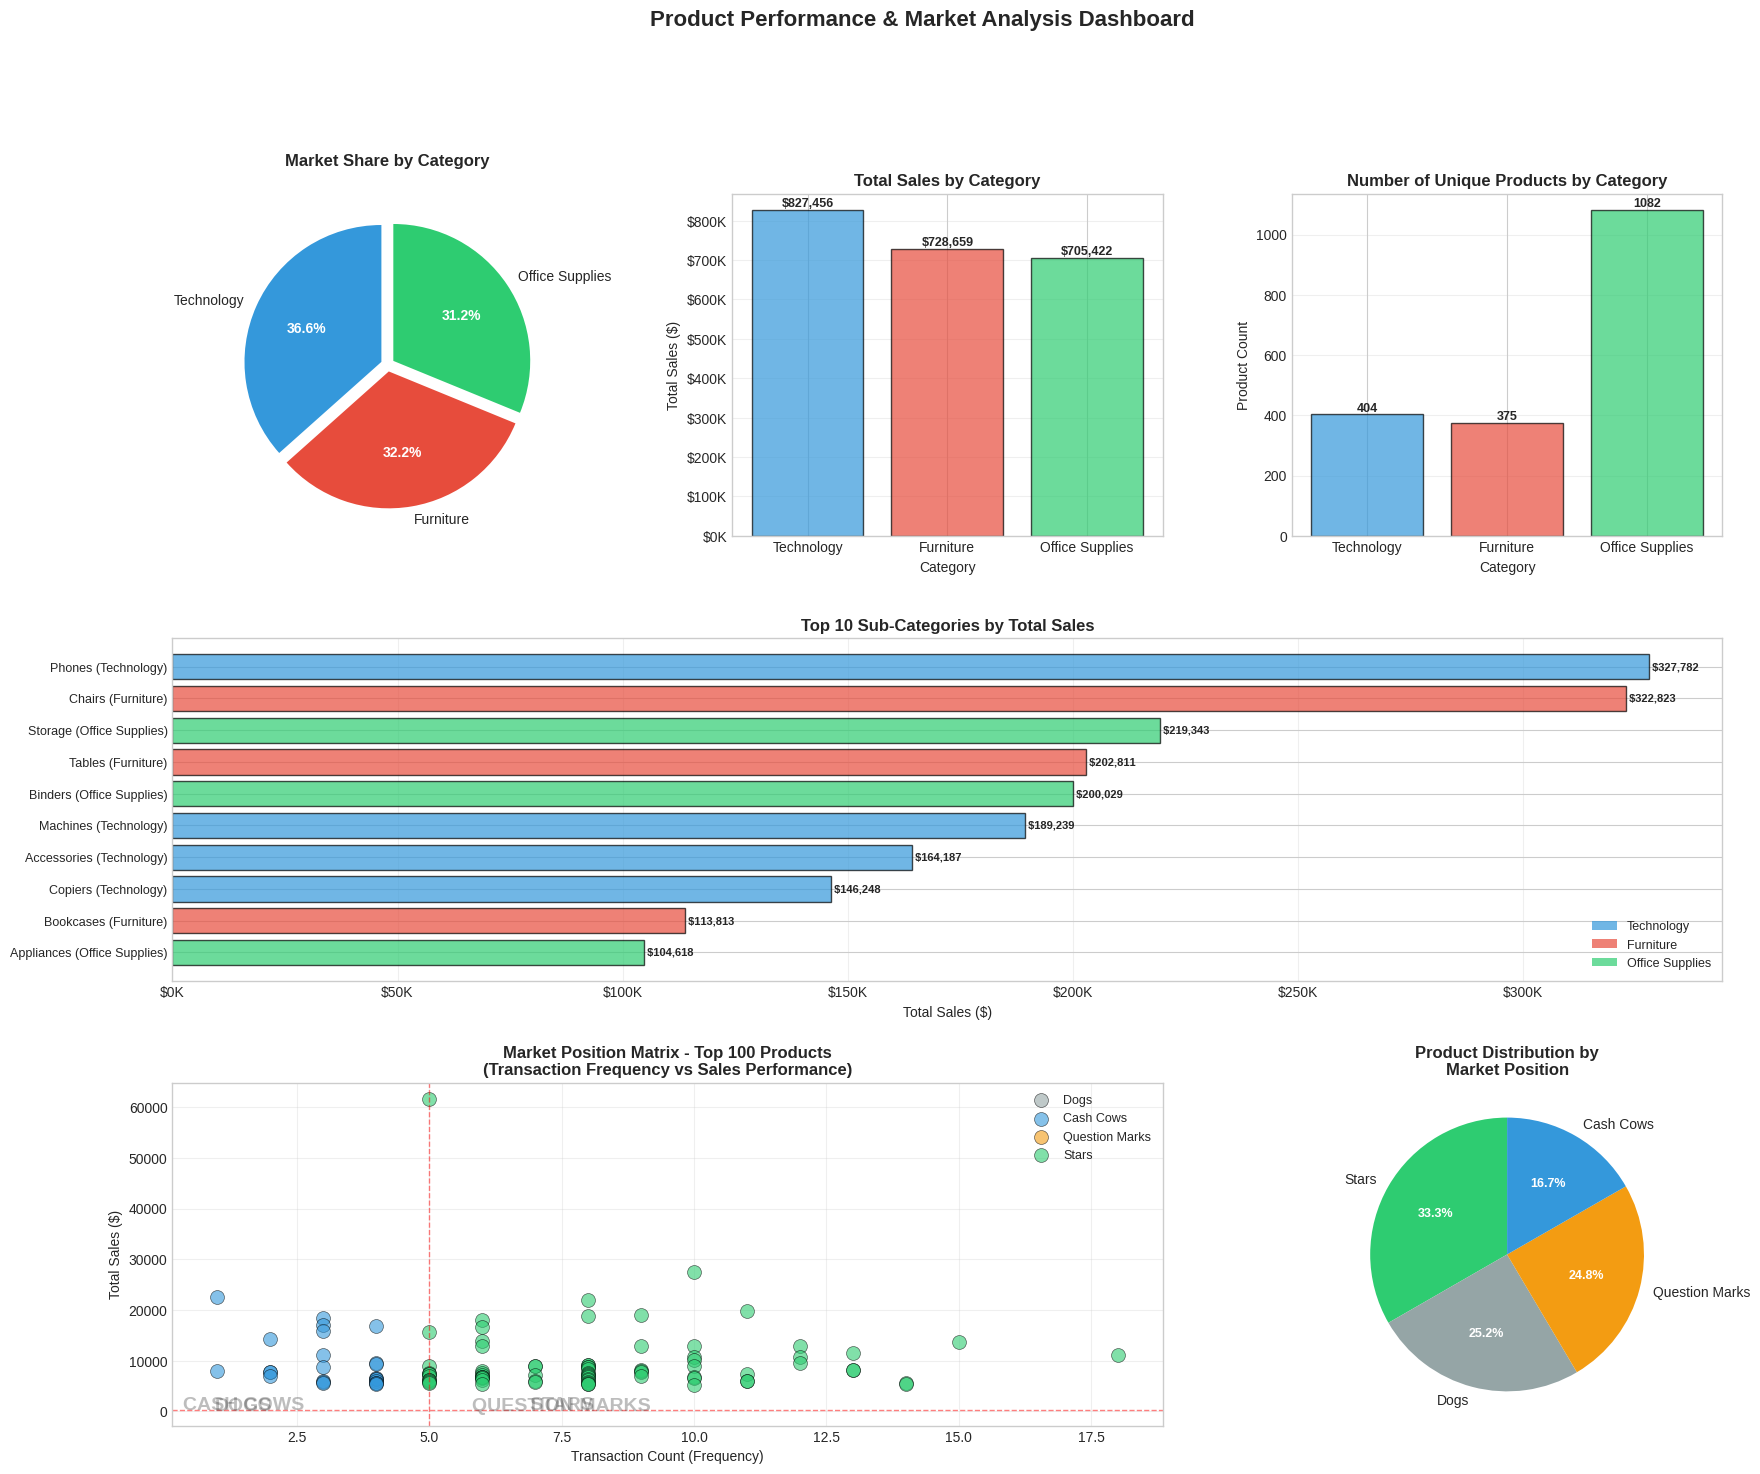


--------------------------------------------------------------------------------
STEP 6: Combined Performance Summary
--------------------------------------------------------------------------------

ABC Class vs Market Position:
Market_Position  Cash Cows  Dogs  Question Marks  Stars   All
ABC_Class                                                    
A                       65     0               0    214   279
B                      129     0               0    242   371
C                      117   469             461    164  1211
All                    311   469             461    620  1861

FSN Class vs Market Position:
Market_Position  Cash Cows  Dogs  Question Marks  Stars   All
FSN_Class                                                    
F                        0     0             121    227   348
N                       94   182               0      0   276
S                      217   287             340    393  1237
All                    311   469             461    620 

In [18]:
# =================================================================================
# SECTION 3: PRODUCT PERFORMANCE ANALYSIS
# Sales Performance, Market Position, and Portfolio Analysis
# =================================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

print("\n" + "="*80)
print("SECTION 3: PRODUCT PERFORMANCE ANALYSIS")
print("="*80)

# =================================================================================
# STEP 1: CATEGORY PERFORMANCE ANALYSIS
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 1: Category Performance Analysis")
print(f"{'-'*80}")

# Aggregate by Category
category_perf = df.groupby('Category').agg({
    'Sales': ['sum', 'mean', 'count'],
    'Product ID': 'nunique'
}).reset_index()

category_perf.columns = ['Category', 'Total_Sales', 'Avg_Transaction',
                          'Total_Transactions', 'Unique_Products']

category_perf = category_perf.sort_values('Total_Sales', ascending=False)

print("\nCategory Performance Summary:")
print(category_perf.to_string(index=False))

# Calculate market share
total_sales = category_perf['Total_Sales'].sum()
category_perf['Market_Share_%'] = (category_perf['Total_Sales'] / total_sales) * 100

print(f"\nMarket Share by Category:")
for idx, row in category_perf.iterrows():
    print(f"  {row['Category']}: {row['Market_Share_%']:.2f}%")

# =================================================================================
# STEP 2: SUB-CATEGORY PERFORMANCE ANALYSIS
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 2: Sub-Category Performance Analysis")
print(f"{'-'*80}")

# Aggregate by Sub-Category
subcat_perf = df.groupby(['Category', 'Sub-Category']).agg({
    'Sales': ['sum', 'mean', 'count'],
    'Product ID': 'nunique'
}).reset_index()

subcat_perf.columns = ['Category', 'Sub_Category', 'Total_Sales',
                        'Avg_Transaction', 'Total_Transactions', 'Unique_Products']

subcat_perf = subcat_perf.sort_values('Total_Sales', ascending=False)

# Top and Bottom 10
print("\nTop 10 Sub-Categories by Sales:")
print(subcat_perf.head(10)[['Category', 'Sub_Category', 'Total_Sales',
                              'Total_Transactions']].to_string(index=False))

print("\nBottom 10 Sub-Categories by Sales:")
print(subcat_perf.tail(10)[['Category', 'Sub_Category', 'Total_Sales',
                              'Total_Transactions']].to_string(index=False))

# =================================================================================
# STEP 3: PRODUCT-LEVEL PERFORMANCE
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 3: Product-Level Performance Analysis")
print(f"{'-'*80}")

# Get product performance from existing product_agg
product_perf = product_agg[['Product_ID', 'Product_Name', 'Category',
                             'Sub_Category', 'Dollar_Usage', 'Order_Count',
                             'ABC_Class', 'FSN_Class', 'Demand_Pattern']].copy()

product_perf = product_perf.rename(columns={
    'Dollar_Usage': 'Total_Sales',
    'Order_Count': 'Transaction_Count'
})

product_perf = product_perf.sort_values('Total_Sales', ascending=False)

print("\nTop 20 Products by Sales:")
print(product_perf.head(20)[['Product_ID', 'Product_Name', 'Category',
                              'Total_Sales', 'Transaction_Count']].to_string(index=False))

print("\nBottom 20 Products by Sales:")
print(product_perf.tail(20)[['Product_ID', 'Product_Name', 'Category',
                              'Total_Sales', 'Transaction_Count']].to_string(index=False))

# =================================================================================
# STEP 4: MARKET POSITION ANALYSIS (BCG MATRIX APPROACH)
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 4: Market Position Analysis (Growth vs Market Share)")
print(f"{'-'*80}")

# Calculate growth rate (using transaction count as proxy)
# Calculate median values for positioning
median_sales = product_perf['Total_Sales'].median()
median_transactions = product_perf['Transaction_Count'].median()

# Classify products into BCG-style quadrants
def classify_market_position(row):
    """
    Classify products based on Sales (Market Share proxy) and Transactions (Growth proxy)
    Stars: High Sales + High Transactions
    Cash Cows: High Sales + Low Transactions
    Question Marks: Low Sales + High Transactions
    Dogs: Low Sales + Low Transactions
    """
    if row['Total_Sales'] >= median_sales and row['Transaction_Count'] >= median_transactions:
        return 'Stars'
    elif row['Total_Sales'] >= median_sales and row['Transaction_Count'] < median_transactions:
        return 'Cash Cows'
    elif row['Total_Sales'] < median_sales and row['Transaction_Count'] >= median_transactions:
        return 'Question Marks'
    else:
        return 'Dogs'

product_perf['Market_Position'] = product_perf.apply(classify_market_position, axis=1)

# Summary by position
position_summary = product_perf.groupby('Market_Position').agg({
    'Product_ID': 'count',
    'Total_Sales': 'sum',
    'Transaction_Count': 'sum'
}).round(2)

position_summary.columns = ['Product_Count', 'Total_Sales', 'Total_Transactions']
position_summary['Avg_Sales_Per_Product'] = (position_summary['Total_Sales'] /
                                               position_summary['Product_Count']).round(2)

print("\nMarket Position Summary:")
print(position_summary)

# Strategic recommendations by position
print("\nStrategic Recommendations by Market Position:")
print("  • Stars: Invest & Grow - High performers with strong momentum")
print("  • Cash Cows: Maintain & Harvest - Stable revenue generators")
print("  • Question Marks: Selective Investment - Evaluate potential")
print("  • Dogs: Review for Phase-Out - Low priority items")

# =================================================================================
# STEP 5: CREATE COMPREHENSIVE VISUALIZATIONS
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 5: Creating Performance Visualizations")
print(f"{'-'*80}")

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
colors_palette = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

# Create main figure with multiple subplots
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# ---------------------------------------------------------------------------------
# CHART 1: Category Market Share (Pie Chart)
# ---------------------------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])
colors_cat = ['#3498db', '#e74c3c', '#2ecc71']
wedges, texts, autotexts = ax1.pie(category_perf['Total_Sales'],
                                     labels=category_perf['Category'],
                                     autopct='%1.1f%%',
                                     colors=colors_cat,
                                     startangle=90,
                                     explode=(0.05, 0.05, 0.05))

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_weight('bold')

ax1.set_title('Market Share by Category', fontsize=12, fontweight='bold', pad=20)
print("  ✓ Chart 1: Category Market Share created")

# ---------------------------------------------------------------------------------
# CHART 2: Category Sales Comparison (Bar Chart)
# ---------------------------------------------------------------------------------
ax2 = fig.add_subplot(gs[0, 1])
bars = ax2.bar(category_perf['Category'], category_perf['Total_Sales'],
               color=colors_cat, alpha=0.7, edgecolor='black')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.0f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax2.set_title('Total Sales by Category', fontsize=12, fontweight='bold')
ax2.set_ylabel('Total Sales ($)', fontsize=10)
ax2.set_xlabel('Category', fontsize=10)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax2.grid(axis='y', alpha=0.3)
print("  ✓ Chart 2: Category Sales Comparison created")

# ---------------------------------------------------------------------------------
# CHART 3: Category Product Count
# ---------------------------------------------------------------------------------
ax3 = fig.add_subplot(gs[0, 2])
bars = ax3.bar(category_perf['Category'], category_perf['Unique_Products'],
               color=colors_cat, alpha=0.7, edgecolor='black')

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax3.set_title('Number of Unique Products by Category', fontsize=12, fontweight='bold')
ax3.set_ylabel('Product Count', fontsize=10)
ax3.set_xlabel('Category', fontsize=10)
ax3.grid(axis='y', alpha=0.3)
print("  ✓ Chart 3: Product Count by Category created")

# ---------------------------------------------------------------------------------
# CHART 4: Top 10 Sub-Categories (Horizontal Bar)
# ---------------------------------------------------------------------------------
ax4 = fig.add_subplot(gs[1, :])
top_subcat = subcat_perf.head(10).sort_values('Total_Sales')

# Color by category
cat_colors = {'Technology': '#3498db', 'Furniture': '#e74c3c', 'Office Supplies': '#2ecc71'}
bar_colors = [cat_colors[cat] for cat in top_subcat['Category']]

bars = ax4.barh(range(len(top_subcat)), top_subcat['Total_Sales'],
                color=bar_colors, alpha=0.7, edgecolor='black')

ax4.set_yticks(range(len(top_subcat)))
ax4.set_yticklabels([f"{row['Sub_Category']} ({row['Category']})"
                      for _, row in top_subcat.iterrows()], fontsize=9)

# Add value labels
for i, (idx, row) in enumerate(top_subcat.iterrows()):
    ax4.text(row['Total_Sales'], i, f" ${row['Total_Sales']:,.0f}",
            va='center', fontsize=8, fontweight='bold')

ax4.set_title('Top 10 Sub-Categories by Total Sales', fontsize=12, fontweight='bold')
ax4.set_xlabel('Total Sales ($)', fontsize=10)
ax4.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax4.grid(axis='x', alpha=0.3)

# Add legend for categories
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=cat_colors[cat], label=cat, alpha=0.7)
                   for cat in cat_colors.keys()]
ax4.legend(handles=legend_elements, loc='lower right', fontsize=9)

print("  ✓ Chart 4: Top Sub-Categories created")

# ---------------------------------------------------------------------------------
# CHART 5: Market Position Matrix (BCG Style)
# ---------------------------------------------------------------------------------
ax5 = fig.add_subplot(gs[2, 0:2])

# Sample products for clearer visualization (top 100 by sales)
top_products = product_perf.head(100).copy()

# Color mapping for market positions
position_colors = {
    'Stars': '#2ecc71',           # Green
    'Cash Cows': '#3498db',       # Blue
    'Question Marks': '#f39c12',  # Orange
    'Dogs': '#95a5a6'             # Gray
}

# Plot scatter
for position in ['Dogs', 'Cash Cows', 'Question Marks', 'Stars']:
    pos_data = top_products[top_products['Market_Position'] == position]
    ax5.scatter(pos_data['Transaction_Count'], pos_data['Total_Sales'],
               c=position_colors[position], label=position,
               s=100, alpha=0.6, edgecolors='black', linewidth=0.5)

# Add median lines
ax5.axhline(y=median_sales, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax5.axvline(x=median_transactions, color='red', linestyle='--', linewidth=1, alpha=0.5)

# Add quadrant labels
ax5.text(median_transactions * 1.5, median_sales * 1.5, 'STARS',
        fontsize=14, alpha=0.3, weight='bold', ha='center')
ax5.text(median_transactions * 0.3, median_sales * 1.5, 'CASH COWS',
        fontsize=14, alpha=0.3, weight='bold', ha='center')
ax5.text(median_transactions * 1.5, median_sales * 0.3, 'QUESTION MARKS',
        fontsize=14, alpha=0.3, weight='bold', ha='center')
ax5.text(median_transactions * 0.3, median_sales * 0.3, 'DOGS',
        fontsize=14, alpha=0.3, weight='bold', ha='center')

ax5.set_title('Market Position Matrix - Top 100 Products\n(Transaction Frequency vs Sales Performance)',
             fontsize=12, fontweight='bold')
ax5.set_xlabel('Transaction Count (Frequency)', fontsize=10)
ax5.set_ylabel('Total Sales ($)', fontsize=10)
ax5.legend(loc='upper right', fontsize=9)
ax5.grid(True, alpha=0.3)
print("  ✓ Chart 5: Market Position Matrix created")

# ---------------------------------------------------------------------------------
# CHART 6: Market Position Distribution (Pie Chart)
# ---------------------------------------------------------------------------------
ax6 = fig.add_subplot(gs[2, 2])

position_counts = product_perf['Market_Position'].value_counts()
colors_pos = [position_colors[pos] for pos in position_counts.index]

wedges, texts, autotexts = ax6.pie(position_counts.values,
                                     labels=position_counts.index,
                                     autopct='%1.1f%%',
                                     colors=colors_pos,
                                     startangle=90)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(9)
    autotext.set_weight('bold')

ax6.set_title('Product Distribution by\nMarket Position', fontsize=12, fontweight='bold')
print("  ✓ Chart 6: Market Position Distribution created")

# Add main title
fig.suptitle('Product Performance & Market Analysis Dashboard',
            fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('product_performance_analysis.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Visualization saved as: product_performance_analysis.png")
plt.show()

# =================================================================================
# STEP 6: PERFORMANCE SUMMARY BY ABC-FSN-POSITION
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 6: Combined Performance Summary")
print(f"{'-'*80}")

# Cross-tabulation: ABC vs Market Position
print("\nABC Class vs Market Position:")
abc_position = pd.crosstab(product_perf['ABC_Class'],
                           product_perf['Market_Position'],
                           margins=True)
print(abc_position)

print("\nFSN Class vs Market Position:")
fsn_position = pd.crosstab(product_perf['FSN_Class'],
                           product_perf['Market_Position'],
                           margins=True)
print(fsn_position)

# Strategic Portfolio Analysis
print(f"\n{'-'*80}")
print("STRATEGIC PORTFOLIO INSIGHTS")
print(f"{'-'*80}")

# Key metrics
total_products = len(product_perf)
stars_count = len(product_perf[product_perf['Market_Position'] == 'Stars'])
cash_cows_count = len(product_perf[product_perf['Market_Position'] == 'Cash Cows'])
dogs_count = len(product_perf[product_perf['Market_Position'] == 'Dogs'])

stars_sales = product_perf[product_perf['Market_Position'] == 'Stars']['Total_Sales'].sum()
total_sales_all = product_perf['Total_Sales'].sum()

print(f"\n1. PORTFOLIO COMPOSITION:")
print(f"   • Total Products: {total_products}")
print(f"   • Stars: {stars_count} ({stars_count/total_products*100:.1f}%)")
print(f"   • Cash Cows: {cash_cows_count} ({cash_cows_count/total_products*100:.1f}%)")
print(f"   • Dogs: {dogs_count} ({dogs_count/total_products*100:.1f}%)")

print(f"\n2. REVENUE CONTRIBUTION:")
print(f"   • Stars contribute: ${stars_sales:,.2f} ({stars_sales/total_sales_all*100:.1f}% of total)")

print(f"\n3. CRITICAL ITEMS (Class A Stars):")
critical_stars = product_perf[(product_perf['ABC_Class'] == 'A') &
                               (product_perf['Market_Position'] == 'Stars')]
print(f"   • {len(critical_stars)} products")
print(f"   • These are your TOP PRIORITY items - invest heavily")

print(f"\n4. UNDERPERFORMERS (Class C Dogs):")
underperformers = product_perf[(product_perf['ABC_Class'] == 'C') &
                                (product_perf['Market_Position'] == 'Dogs')]
print(f"   • {len(underperformers)} products")
print(f"   • Consider phase-out or discontinuation")

print(f"\n5. GROWTH OPPORTUNITIES (Question Marks with Class A/B):")
opportunities = product_perf[(product_perf['Market_Position'] == 'Question Marks') &
                              (product_perf['ABC_Class'].isin(['A', 'B']))]
print(f"   • {len(opportunities)} products")
print(f"   • High potential - need marketing/promotion push")

print(f"\n{'='*80}")
print("✓ SECTION 3: PRODUCT PERFORMANCE ANALYSIS COMPLETE")
print(f"{'='*80}")


SECTION 4: CUSTOMER SEGMENTATION & RFM ANALYSIS
CLV Analysis with Personalized Discount Recommendations

--------------------------------------------------------------------------------
STEP 1: Calculating RFM Metrics
--------------------------------------------------------------------------------
Analysis Reference Date: 2018-12-31

✓ RFM metrics calculated for 793 customers

RFM Summary Statistics:
  Recency (days):
    - Mean: 149.3
    - Median: 76.0
  Frequency (orders):
    - Mean: 12.4
    - Median: 11.0
  Monetary (sales):
    - Mean: $2,851.87
    - Median: $2,215.00

--------------------------------------------------------------------------------
STEP 2: Calculating Customer Lifetime Value (CLV)
--------------------------------------------------------------------------------

✓ CLV calculated successfully

CLV Summary Statistics:
  Mean CLV: $3,334.89
  Median CLV: $768.20
  Total CLV: $2,644,570.64

---------------------------------------------------------------------------

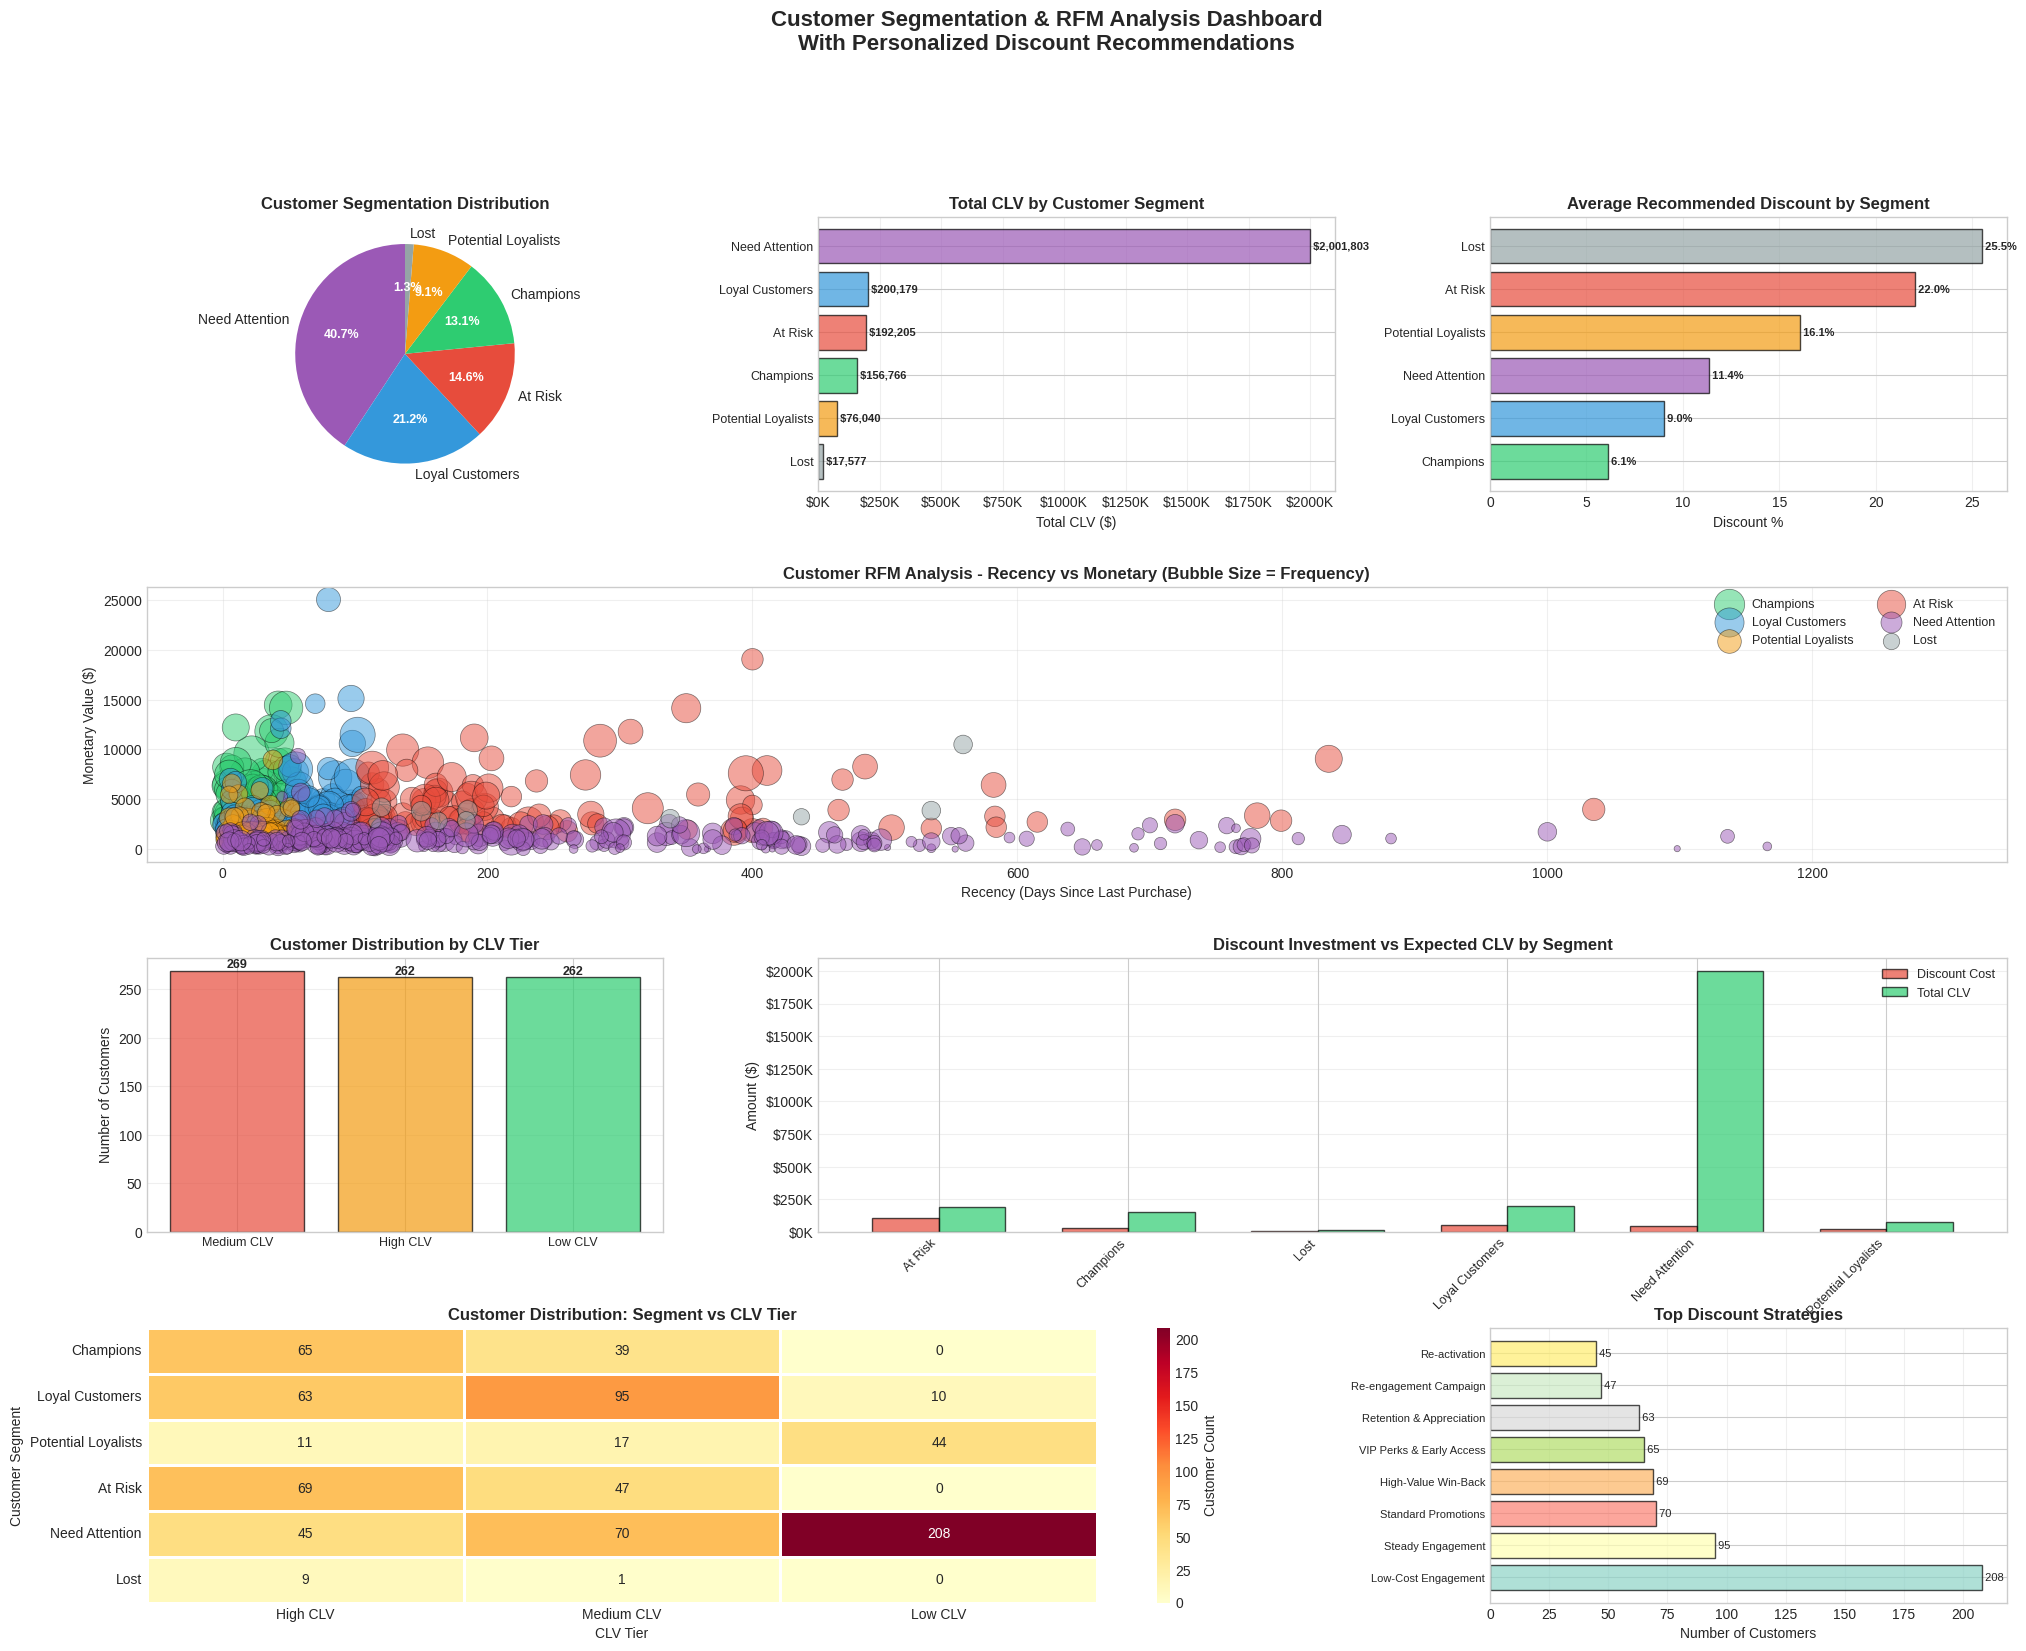


--------------------------------------------------------------------------------
STEP 10: Key Insights & Actionable Recommendations
--------------------------------------------------------------------------------

KEY BUSINESS INSIGHTS

1. OVERALL CUSTOMER VALUE:
   • Total Customer Base: 793 customers
   • Total Lifetime Value: $2,644,570.64
   • Estimated Discount Investment: $271,053.11
   • Expected ROI Ratio: 9.76x

2. CHAMPION CUSTOMERS (TOP PRIORITY):
   • Count: 104 customers (13.1%)
   • Total CLV: $156,766.11 (5.9% of total)
   • Strategy: Minimal discounts (5-10%), focus on VIP perks
   • Action: Implement loyalty program with exclusive benefits

3. AT-RISK HIGH-VALUE CUSTOMERS (URGENT):
   • Count: 69 customers
   • Potential CLV at Risk: $154,378.36
   • Recommended Discount: 20-30%
   • Action: Launch immediate win-back campaign with personalized outreach

4. LOST HIGH-VALUE CUSTOMERS (RECOVERY OPPORTUNITY):
   • Count: 9 customers
   • Recovery Potential: $16,811.24
   

In [19]:
# =================================================================================
# SECTION 4: CUSTOMER SEGMENTATION & RFM ANALYSIS WITH DISCOUNT RECOMMENDATIONS
# CLV, RFM Scoring, and Personalized Discount Strategy
# =================================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from datetime import datetime, timedelta

print("\n" + "="*80)
print("SECTION 4: CUSTOMER SEGMENTATION & RFM ANALYSIS")
print("CLV Analysis with Personalized Discount Recommendations")
print("="*80)

# =================================================================================
# STEP 1: CALCULATE RFM METRICS
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 1: Calculating RFM Metrics")
print(f"{'-'*80}")

# Get the most recent date in the dataset
current_date = df['Order Date'].max() + timedelta(days=1)
print(f"Analysis Reference Date: {current_date.strftime('%Y-%m-%d')}")

# Calculate RFM for each customer
rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (current_date - x.max()).days,  # Recency
    'Order ID': 'count',                                      # Frequency
    'Sales': 'sum',                                          # Monetary
    'Customer Name': 'first',
    'Segment': 'first'
}).reset_index()

rfm.columns = ['Customer_ID', 'Recency', 'Frequency', 'Monetary',
               'Customer_Name', 'Customer_Segment']

print(f"\n✓ RFM metrics calculated for {len(rfm)} customers")
print(f"\nRFM Summary Statistics:")
print(f"  Recency (days):")
print(f"    - Mean: {rfm['Recency'].mean():.1f}")
print(f"    - Median: {rfm['Recency'].median():.1f}")
print(f"  Frequency (orders):")
print(f"    - Mean: {rfm['Frequency'].mean():.1f}")
print(f"    - Median: {rfm['Frequency'].median():.1f}")
print(f"  Monetary (sales):")
print(f"    - Mean: ${rfm['Monetary'].mean():,.2f}")
print(f"    - Median: ${rfm['Monetary'].median():,.2f}")

# =================================================================================
# STEP 2: CALCULATE CUSTOMER LIFETIME VALUE (CLV)
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 2: Calculating Customer Lifetime Value (CLV)")
print(f"{'-'*80}")

# Simple CLV calculation
# CLV = (Average Order Value × Purchase Frequency × Customer Lifespan) × Profit Margin
# Assumptions:
# - Customer lifespan: estimated based on activity period
# - Profit margin: 30% (industry average for retail)

# Calculate additional metrics
rfm['Avg_Order_Value'] = rfm['Monetary'] / rfm['Frequency']

# Calculate customer lifespan (days active)
customer_lifespan = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (x.max() - x.min()).days + 1
}).reset_index()
customer_lifespan.columns = ['Customer_ID', 'Lifespan_Days']

rfm = rfm.merge(customer_lifespan, on='Customer_ID', how='left')

# Estimate purchase frequency per year
rfm['Purchase_Frequency_Yearly'] = (rfm['Frequency'] / rfm['Lifespan_Days']) * 365
rfm['Purchase_Frequency_Yearly'] = rfm['Purchase_Frequency_Yearly'].replace([np.inf], 0)

# CLV Calculation
PROFIT_MARGIN = 0.30
CUSTOMER_LIFESPAN_YEARS = 3  # Expected future relationship duration

rfm['CLV'] = (rfm['Avg_Order_Value'] *
              rfm['Purchase_Frequency_Yearly'] *
              CUSTOMER_LIFESPAN_YEARS *
              PROFIT_MARGIN)

# Handle edge cases
rfm['CLV'] = rfm['CLV'].replace([np.inf, -np.inf], 0)
rfm['CLV'] = rfm['CLV'].fillna(0)

print(f"\n✓ CLV calculated successfully")
print(f"\nCLV Summary Statistics:")
print(f"  Mean CLV: ${rfm['CLV'].mean():,.2f}")
print(f"  Median CLV: ${rfm['CLV'].median():,.2f}")
print(f"  Total CLV: ${rfm['CLV'].sum():,.2f}")

# =================================================================================
# STEP 3: RFM SCORING (1-5 SCALE)
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 3: RFM Scoring (Quintile-based)")
print(f"{'-'*80}")

# Create RFM scores (1-5, where 5 is best)
# Note: For Recency, lower is better, so we reverse the ranking
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# Convert to integer
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

# Calculate RFM Score (combined)
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score_Value'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

print(f"✓ RFM Scoring completed")

# =================================================================================
# STEP 4: CUSTOMER SEGMENTATION BASED ON RFM
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 4: Customer Segmentation")
print(f"{'-'*80}")

def segment_customers(row):
    """
    Segment customers based on RFM scores
    """
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']

    # Champions: Best customers (RFM: 5-5-5, 5-5-4, 5-4-5, 4-5-5)
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'

    # Loyal Customers: Recent buyers, frequent purchasers
    elif r >= 3 and f >= 3 and m >= 3:
        return 'Loyal Customers'

    # Potential Loyalists: Recent customers with good frequency
    elif r >= 4 and f >= 2 and m >= 2:
        return 'Potential Loyalists'

    # At Risk: Used to purchase frequently but haven't recently
    elif r <= 2 and f >= 3 and m >= 3:
        return 'At Risk'

    # Need Attention: Below average recency, frequency & monetary
    elif r <= 3 and f <= 3 and m <= 3:
        return 'Need Attention'

    # Lost: Lowest recency, frequency & monetary
    elif r <= 2 and f <= 2:
        return 'Lost'

    else:
        return 'Need Attention'

rfm['Segment'] = rfm.apply(segment_customers, axis=1)

# Segment summary
segment_summary = rfm.groupby('Segment').agg({
    'Customer_ID': 'count',
    'Monetary': 'mean',
    'CLV': 'mean',
    'Recency': 'mean',
    'Frequency': 'mean'
}).round(2)

segment_summary.columns = ['Customer_Count', 'Avg_Monetary', 'Avg_CLV',
                           'Avg_Recency', 'Avg_Frequency']
segment_summary = segment_summary.sort_values('Avg_CLV', ascending=False)

print(f"\nCustomer Segmentation Summary:")
print(segment_summary)

# Calculate segment percentages
total_customers = len(rfm)
print(f"\nSegment Distribution:")
for segment in segment_summary.index:
    count = segment_summary.loc[segment, 'Customer_Count']
    pct = (count / total_customers) * 100
    avg_spend = segment_summary.loc[segment, 'Avg_Monetary']
    print(f"  {segment}: {int(count)} customers ({pct:.1f}%) - Avg Spend: ${avg_spend:,.2f}")

# =================================================================================
# STEP 5: CLV-RFM COMBINED CLASSIFICATION FOR DISCOUNT STRATEGY
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 5: CLV-RFM Combined Classification for Discount Strategy")
print(f"{'-'*80}")

# Classify CLV into tiers
clv_percentiles = rfm['CLV'].quantile([0.33, 0.67])

def classify_clv_tier(clv):
    """Classify CLV into High/Medium/Low tiers"""
    if clv >= clv_percentiles[0.67]:
        return 'High CLV'
    elif clv >= clv_percentiles[0.33]:
        return 'Medium CLV'
    else:
        return 'Low CLV'

rfm['CLV_Tier'] = rfm['CLV'].apply(classify_clv_tier)

# Combined classification
rfm['Strategic_Segment'] = rfm['Segment'] + ' - ' + rfm['CLV_Tier']

print(f"✓ CLV Tiers defined:")
print(f"  High CLV: ≥ ${clv_percentiles[0.67]:,.2f}")
print(f"  Medium CLV: ${clv_percentiles[0.33]:,.2f} - ${clv_percentiles[0.67]:,.2f}")
print(f"  Low CLV: < ${clv_percentiles[0.33]:,.2f}")

# =================================================================================
# STEP 6: PERSONALIZED DISCOUNT RECOMMENDATIONS
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 6: Personalized Discount Recommendations")
print(f"{'-'*80}")

def assign_discount_strategy(row):
    """
    Assign discount percentage and strategy based on Segment and CLV Tier

    Strategy Principles:
    1. Champions (High CLV) - Minimal discounts, focus on exclusive perks
    2. Loyal Customers (High CLV) - Modest discounts to maintain loyalty
    3. Potential Loyalists - Aggressive discounts to convert
    4. At Risk (High CLV) - Win-back campaigns with significant discounts
    5. Need Attention - Standard promotional discounts
    6. Lost - Deep discounts to re-engage (if worth it)
    """
    segment = row['Segment']
    clv_tier = row['CLV_Tier']

    # Champions Strategy
    if segment == 'Champions':
        if clv_tier == 'High CLV':
            return {
                'discount_pct': 5,
                'strategy': 'VIP Perks & Early Access',
                'action': 'Exclusive previews, free shipping, priority support',
                'frequency': 'Quarterly',
                'max_discount': 10
            }
        elif clv_tier == 'Medium CLV':
            return {
                'discount_pct': 8,
                'strategy': 'Premium Loyalty Rewards',
                'action': 'Birthday specials, loyalty points boost',
                'frequency': 'Monthly',
                'max_discount': 15
            }
        else:
            return {
                'discount_pct': 10,
                'strategy': 'Growth Incentives',
                'action': 'Tiered rewards to increase purchase value',
                'frequency': 'Bi-weekly',
                'max_discount': 20
            }

    # Loyal Customers Strategy
    elif segment == 'Loyal Customers':
        if clv_tier == 'High CLV':
            return {
                'discount_pct': 7,
                'strategy': 'Retention & Appreciation',
                'action': 'Thank you bonuses, surprise gifts',
                'frequency': 'Monthly',
                'max_discount': 12
            }
        elif clv_tier == 'Medium CLV':
            return {
                'discount_pct': 10,
                'strategy': 'Steady Engagement',
                'action': 'Regular promotions, bundle deals',
                'frequency': 'Bi-weekly',
                'max_discount': 18
            }
        else:
            return {
                'discount_pct': 12,
                'strategy': 'Value Enhancement',
                'action': 'Spend-threshold bonuses',
                'frequency': 'Weekly',
                'max_discount': 22
            }

    # Potential Loyalists Strategy
    elif segment == 'Potential Loyalists':
        if clv_tier == 'High CLV':
            return {
                'discount_pct': 10,
                'strategy': 'Conversion Acceleration',
                'action': 'Next-purchase coupons, product trials',
                'frequency': 'Weekly',
                'max_discount': 20
            }
        elif clv_tier == 'Medium CLV':
            return {
                'discount_pct': 15,
                'strategy': 'Loyalty Building',
                'action': 'Multi-buy discounts, referral bonuses',
                'frequency': 'Weekly',
                'max_discount': 25
            }
        else:
            return {
                'discount_pct': 18,
                'strategy': 'Aggressive Conversion',
                'action': 'First-time buyer incentives, flash sales',
                'frequency': 'Daily',
                'max_discount': 30
            }

    # At Risk Strategy
    elif segment == 'At Risk':
        if clv_tier == 'High CLV':
            return {
                'discount_pct': 20,
                'strategy': 'High-Value Win-Back',
                'action': 'Personalized offers, concierge service',
                'frequency': 'Immediate',
                'max_discount': 30
            }
        elif clv_tier == 'Medium CLV':
            return {
                'discount_pct': 25,
                'strategy': 'Re-engagement Campaign',
                'action': 'We miss you emails, special comeback deals',
                'frequency': 'Immediate',
                'max_discount': 35
            }
        else:
            return {
                'discount_pct': 15,
                'strategy': 'Selective Win-Back',
                'action': 'Survey + incentive, limited offers',
                'frequency': 'One-time',
                'max_discount': 25
            }

    # Need Attention Strategy
    elif segment == 'Need Attention':
        if clv_tier == 'High CLV':
            return {
                'discount_pct': 12,
                'strategy': 'Re-activation',
                'action': 'Targeted campaigns, product recommendations',
                'frequency': 'Bi-weekly',
                'max_discount': 20
            }
        elif clv_tier == 'Medium CLV':
            return {
                'discount_pct': 15,
                'strategy': 'Standard Promotions',
                'action': 'Seasonal sales, category discounts',
                'frequency': 'Weekly',
                'max_discount': 25
            }
        else:
            return {
                'discount_pct': 10,
                'strategy': 'Low-Cost Engagement',
                'action': 'Email campaigns, social media ads',
                'frequency': 'Monthly',
                'max_discount': 18
            }

    # Lost Customers Strategy
    else:  # Lost
        if clv_tier == 'High CLV':
            return {
                'discount_pct': 25,
                'strategy': 'Premium Recovery',
                'action': 'Personal outreach, premium incentives',
                'frequency': 'One-time',
                'max_discount': 40
            }
        elif clv_tier == 'Medium CLV':
            return {
                'discount_pct': 30,
                'strategy': 'Deep Discount Recovery',
                'action': 'Clearance access, major discounts',
                'frequency': 'One-time',
                'max_discount': 45
            }
        else:
            return {
                'discount_pct': 0,
                'strategy': 'No Investment',
                'action': 'Remove from active marketing',
                'frequency': 'None',
                'max_discount': 0
            }

# Apply discount strategy
discount_data = rfm.apply(assign_discount_strategy, axis=1)

rfm['Discount_Pct'] = discount_data.apply(lambda x: x['discount_pct'])
rfm['Discount_Strategy'] = discount_data.apply(lambda x: x['strategy'])
rfm['Action_Plan'] = discount_data.apply(lambda x: x['action'])
rfm['Campaign_Frequency'] = discount_data.apply(lambda x: x['frequency'])
rfm['Max_Discount_Pct'] = discount_data.apply(lambda x: x['max_discount'])

# Calculate estimated discount cost
rfm['Estimated_Discount_Cost'] = rfm['Monetary'] * (rfm['Discount_Pct'] / 100)

print(f"\n✓ Discount strategies assigned to all customers")

# Discount strategy summary
discount_summary = rfm.groupby(['Segment', 'CLV_Tier']).agg({
    'Customer_ID': 'count',
    'Discount_Pct': 'mean',
    'Estimated_Discount_Cost': 'sum',
    'CLV': 'sum',
    'Monetary': 'sum'
}).round(2)

discount_summary.columns = ['Customer_Count', 'Avg_Discount_%', 'Total_Discount_Cost',
                            'Total_CLV', 'Total_Revenue']
discount_summary['ROI_Ratio'] = (discount_summary['Total_CLV'] /
                                  discount_summary['Total_Discount_Cost']).round(2)

print(f"\nDiscount Strategy Summary by Segment & CLV Tier:")
print(discount_summary.sort_values('Total_CLV', ascending=False))

# =================================================================================
# STEP 7: TOP CUSTOMERS & DISCOUNT RECOMMENDATIONS
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 7: Top Customers with Personalized Discount Recommendations")
print(f"{'-'*80}")

# Top 10 by CLV
top_10_clv = rfm.nlargest(10, 'CLV')[['Customer_ID', 'Customer_Name', 'Customer_Segment',
                                        'Segment', 'CLV_Tier', 'Recency', 'Frequency',
                                        'Monetary', 'CLV', 'Discount_Pct',
                                        'Discount_Strategy', 'Action_Plan']].copy()

print("\nTop 10 Customers by CLV:")
print(top_10_clv.to_string(index=False))

# =================================================================================
# STEP 8: SEGMENT PERFORMANCE BY CUSTOMER TYPE
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 8: Segment Performance Analysis")
print(f"{'-'*80}")

segment_perf = df.groupby('Segment').agg({
    'Sales': 'sum',
    'Order ID': 'count',
    'Customer ID': 'nunique'
}).reset_index()

segment_perf.columns = ['Segment', 'Total_Sales', 'Total_Orders', 'Unique_Customers']
segment_perf['Avg_Order_Value'] = segment_perf['Total_Sales'] / segment_perf['Total_Orders']

print("\nSegment Performance (Consumer vs Corporate vs Home Office):")
print(segment_perf.to_string(index=False))

# =================================================================================
# STEP 9: CREATE COMPREHENSIVE VISUALIZATIONS
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 9: Creating Customer Segmentation Visualizations")
print(f"{'-'*80}")

# Set style
plt.style.use('seaborn-v0_8-whitegrid')

# Create main figure
fig = plt.figure(figsize=(24, 18))
gs = GridSpec(4, 3, figure=fig, hspace=0.35, wspace=0.3)

# Color palettes
segment_colors = {
    'Champions': '#2ecc71',
    'Loyal Customers': '#3498db',
    'Potential Loyalists': '#f39c12',
    'At Risk': '#e74c3c',
    'Need Attention': '#9b59b6',
    'Lost': '#95a5a6'
}

# ---------------------------------------------------------------------------------
# CHART 1: Customer Segmentation Distribution
# ---------------------------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])
segment_counts = rfm['Segment'].value_counts()
colors = [segment_colors[seg] for seg in segment_counts.index]

wedges, texts, autotexts = ax1.pie(segment_counts.values,
                                     labels=segment_counts.index,
                                     autopct='%1.1f%%',
                                     colors=colors,
                                     startangle=90)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(9)
    autotext.set_weight('bold')

ax1.set_title('Customer Segmentation Distribution', fontsize=12, fontweight='bold')
print("  ✓ Chart 1: Segmentation Distribution created")

# ---------------------------------------------------------------------------------
# CHART 2: CLV by Segment
# ---------------------------------------------------------------------------------
ax2 = fig.add_subplot(gs[0, 1])
clv_by_segment = rfm.groupby('Segment')['CLV'].sum().sort_values(ascending=True)
colors = [segment_colors[seg] for seg in clv_by_segment.index]

bars = ax2.barh(range(len(clv_by_segment)), clv_by_segment.values,
                color=colors, alpha=0.7, edgecolor='black')

ax2.set_yticks(range(len(clv_by_segment)))
ax2.set_yticklabels(clv_by_segment.index, fontsize=9)

for i, (seg, val) in enumerate(clv_by_segment.items()):
    ax2.text(val, i, f' ${val:,.0f}', va='center', fontsize=8, fontweight='bold')

ax2.set_title('Total CLV by Customer Segment', fontsize=12, fontweight='bold')
ax2.set_xlabel('Total CLV ($)', fontsize=10)
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax2.grid(axis='x', alpha=0.3)
print("  ✓ Chart 2: CLV by Segment created")

# ---------------------------------------------------------------------------------
# CHART 3: Average Discount by Segment
# ---------------------------------------------------------------------------------
ax3 = fig.add_subplot(gs[0, 2])
discount_by_segment = rfm.groupby('Segment')['Discount_Pct'].mean().sort_values(ascending=True)
colors = [segment_colors[seg] for seg in discount_by_segment.index]

bars = ax3.barh(range(len(discount_by_segment)), discount_by_segment.values,
                color=colors, alpha=0.7, edgecolor='black')

ax3.set_yticks(range(len(discount_by_segment)))
ax3.set_yticklabels(discount_by_segment.index, fontsize=9)

for i, (seg, val) in enumerate(discount_by_segment.items()):
    ax3.text(val, i, f' {val:.1f}%', va='center', fontsize=8, fontweight='bold')

ax3.set_title('Average Recommended Discount by Segment', fontsize=12, fontweight='bold')
ax3.set_xlabel('Discount %', fontsize=10)
ax3.grid(axis='x', alpha=0.3)
print("  ✓ Chart 3: Discount by Segment created")

# ---------------------------------------------------------------------------------
# CHART 4: RFM Score Distribution (Scatter)
# ---------------------------------------------------------------------------------
ax4 = fig.add_subplot(gs[1, :])

for segment in segment_colors.keys():
    seg_data = rfm[rfm['Segment'] == segment]
    ax4.scatter(seg_data['Recency'], seg_data['Monetary'],
               s=seg_data['Frequency']*20, alpha=0.5,
               c=segment_colors[segment], label=segment,
               edgecolors='black', linewidth=0.5)

ax4.set_title('Customer RFM Analysis - Recency vs Monetary (Bubble Size = Frequency)',
             fontsize=12, fontweight='bold')
ax4.set_xlabel('Recency (Days Since Last Purchase)', fontsize=10)
ax4.set_ylabel('Monetary Value ($)', fontsize=10)
ax4.legend(loc='upper right', fontsize=9, ncol=2)
ax4.grid(True, alpha=0.3)
ax4.set_xlim(right=ax4.get_xlim()[1] * 1.1)
print("  ✓ Chart 4: RFM Scatter Plot created")

# ---------------------------------------------------------------------------------
# CHART 5: CLV Tier Distribution
# ---------------------------------------------------------------------------------
ax5 = fig.add_subplot(gs[2, 0])
clv_tier_counts = rfm['CLV_Tier'].value_counts()
clv_colors = ['#e74c3c', '#f39c12', '#2ecc71']

bars = ax5.bar(range(len(clv_tier_counts)), clv_tier_counts.values,
              color=clv_colors, alpha=0.7, edgecolor='black')

ax5.set_xticks(range(len(clv_tier_counts)))
ax5.set_xticklabels(clv_tier_counts.index, fontsize=9)

for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax5.set_title('Customer Distribution by CLV Tier', fontsize=12, fontweight='bold')
ax5.set_ylabel('Number of Customers', fontsize=10)
ax5.grid(axis='y', alpha=0.3)
print("  ✓ Chart 5: CLV Tier Distribution created")

# ---------------------------------------------------------------------------------
# CHART 6: Discount Cost vs CLV by Segment
# ---------------------------------------------------------------------------------
ax6 = fig.add_subplot(gs[2, 1:])
segment_metrics = rfm.groupby('Segment').agg({
    'Estimated_Discount_Cost': 'sum',
    'CLV': 'sum'
}).reset_index()

x = np.arange(len(segment_metrics))
width = 0.35

bars1 = ax6.bar(x - width/2, segment_metrics['Estimated_Discount_Cost'],
                width, label='Discount Cost', color='#e74c3c', alpha=0.7, edgecolor='black')
bars2 = ax6.bar(x + width/2, segment_metrics['CLV'],
                width, label='Total CLV', color='#2ecc71', alpha=0.7, edgecolor='black')

ax6.set_xticks(x)
ax6.set_xticklabels(segment_metrics['Segment'], rotation=45, ha='right', fontsize=9)
ax6.set_title('Discount Investment vs Expected CLV by Segment', fontsize=12, fontweight='bold')
ax6.set_ylabel('Amount ($)', fontsize=10)
ax6.legend(fontsize=9)
ax6.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax6.grid(axis='y', alpha=0.3)
print("  ✓ Chart 6: Discount Cost vs CLV created")

# ---------------------------------------------------------------------------------
# CHART 7: Segment-CLV Tier Matrix (Heatmap)
# ---------------------------------------------------------------------------------
ax7 = fig.add_subplot(gs[3, :2])

# Create pivot table
heatmap_data = pd.crosstab(rfm['Segment'], rfm['CLV_Tier'])
heatmap_data = heatmap_data.reindex(['Champions', 'Loyal Customers', 'Potential Loyalists',
                                      'At Risk', 'Need Attention', 'Lost'])
heatmap_data = heatmap_data[['High CLV', 'Medium CLV', 'Low CLV']]

sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd',
            cbar_kws={'label': 'Customer Count'},
            linewidths=1, linecolor='white', ax=ax7)

ax7.set_title('Customer Distribution: Segment vs CLV Tier', fontsize=12, fontweight='bold')
ax7.set_xlabel('CLV Tier', fontsize=10)
ax7.set_ylabel('Customer Segment', fontsize=10)
print("  ✓ Chart 7: Segment-CLV Matrix created")

# ---------------------------------------------------------------------------------
# CHART 8: Discount Strategy Distribution
# ---------------------------------------------------------------------------------
ax8 = fig.add_subplot(gs[3, 2])

strategy_counts = rfm['Discount_Strategy'].value_counts().head(8)
colors_strategy = plt.cm.Set3(np.linspace(0, 1, len(strategy_counts)))

bars = ax8.barh(range(len(strategy_counts)), strategy_counts.values,
               color=colors_strategy, alpha=0.7, edgecolor='black')

ax8.set_yticks(range(len(strategy_counts)))
ax8.set_yticklabels([s[:25] + '...' if len(s) > 25 else s
                      for s in strategy_counts.index], fontsize=8)

for i, val in enumerate(strategy_counts.values):
    ax8.text(val, i, f' {val}', va='center', fontsize=8)

ax8.set_title('Top Discount Strategies', fontsize=12, fontweight='bold')
ax8.set_xlabel('Number of Customers', fontsize=10)
ax8.grid(axis='x', alpha=0.3)
print("  ✓ Chart 8: Discount Strategy Distribution created")

# Add main title
fig.suptitle('Customer Segmentation & RFM Analysis Dashboard\nWith Personalized Discount Recommendations',
            fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('customer_segmentation_rfm_analysis.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Visualization saved as: customer_segmentation_rfm_analysis.png")
plt.show()

# =================================================================================
# STEP 10: ACTIONABLE INSIGHTS & RECOMMENDATIONS
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 10: Key Insights & Actionable Recommendations")
print(f"{'-'*80}")

# Calculate key metrics
total_clv = rfm['CLV'].sum()
total_discount_cost = rfm['Estimated_Discount_Cost'].sum()
roi_ratio = total_clv / total_discount_cost if total_discount_cost > 0 else 0

champions_count = len(rfm[rfm['Segment'] == 'Champions'])
champions_clv = rfm[rfm['Segment'] == 'Champions']['CLV'].sum()
champions_pct = (champions_clv / total_clv) * 100

at_risk_high_clv = rfm[(rfm['Segment'] == 'At Risk') & (rfm['CLV_Tier'] == 'High CLV')]
lost_high_clv = rfm[(rfm['Segment'] == 'Lost') & (rfm['CLV_Tier'] == 'High CLV')]

print(f"\n{'='*80}")
print("KEY BUSINESS INSIGHTS")
print(f"{'='*80}")

print(f"\n1. OVERALL CUSTOMER VALUE:")
print(f"   • Total Customer Base: {len(rfm)} customers")
print(f"   • Total Lifetime Value: ${total_clv:,.2f}")
print(f"   • Estimated Discount Investment: ${total_discount_cost:,.2f}")
print(f"   • Expected ROI Ratio: {roi_ratio:.2f}x")

print(f"\n2. CHAMPION CUSTOMERS (TOP PRIORITY):")
print(f"   • Count: {champions_count} customers ({champions_count/len(rfm)*100:.1f}%)")
print(f"   • Total CLV: ${champions_clv:,.2f} ({champions_pct:.1f}% of total)")
print(f"   • Strategy: Minimal discounts (5-10%), focus on VIP perks")
print(f"   • Action: Implement loyalty program with exclusive benefits")

print(f"\n3. AT-RISK HIGH-VALUE CUSTOMERS (URGENT):")
print(f"   • Count: {len(at_risk_high_clv)} customers")
print(f"   • Potential CLV at Risk: ${at_risk_high_clv['CLV'].sum():,.2f}")
print(f"   • Recommended Discount: 20-30%")
print(f"   • Action: Launch immediate win-back campaign with personalized outreach")

print(f"\n4. LOST HIGH-VALUE CUSTOMERS (RECOVERY OPPORTUNITY):")
print(f"   • Count: {len(lost_high_clv)} customers")
print(f"   • Recovery Potential: ${lost_high_clv['CLV'].sum():,.2f}")
print(f"   • Recommended Discount: Up to 40%")
print(f"   • Action: Premium recovery campaign with deep discounts")

print(f"\n5. POTENTIAL LOYALISTS (GROWTH OPPORTUNITY):")
potential = rfm[rfm['Segment'] == 'Potential Loyalists']
print(f"   • Count: {len(potential)} customers")
print(f"   • Growth Potential: ${potential['CLV'].sum():,.2f}")
print(f"   • Recommended Discount: 10-18%")
print(f"   • Action: Conversion campaigns with tiered incentives")

print(f"\n{'='*80}")
print("DISCOUNT STRATEGY RECOMMENDATIONS BY SEGMENT")
print(f"{'='*80}")

for segment in ['Champions', 'Loyal Customers', 'Potential Loyalists',
                'At Risk', 'Need Attention', 'Lost']:
    seg_data = rfm[rfm['Segment'] == segment]
    if len(seg_data) > 0:
        avg_discount = seg_data['Discount_Pct'].mean()
        strategy = seg_data['Discount_Strategy'].mode()[0]
        action = seg_data['Action_Plan'].mode()[0]

        print(f"\n{segment.upper()}:")
        print(f"  Customers: {len(seg_data)}")
        print(f"  Average Discount: {avg_discount:.1f}%")
        print(f"  Strategy: {strategy}")
        print(f"  Actions: {action}")


SECTION 5: GEOGRAPHIC & MARKET ANALYSIS
Regional Performance & Advertising Target Recommendations

--------------------------------------------------------------------------------
STEP 1: Regional Performance Analysis
--------------------------------------------------------------------------------

Regional Performance Summary:
 Region  Total_Sales  Market_Share_%  Unique_Customers  Sales_Per_Customer
   West  710219.6845       31.404295               681         1042.907026
   East  669518.7260       29.604591               669         1000.775375
Central  492646.9132       21.783723               626          786.975900
  South  389151.4590       17.207390               509          764.541177

Key Regional Insights:
  West:
    - Market Share: 31.40%
    - Customers: 681
    - Avg Sales/Customer: $1,042.91
  East:
    - Market Share: 29.60%
    - Customers: 669
    - Avg Sales/Customer: $1,000.78
  Central:
    - Market Share: 21.78%
    - Customers: 626
    - Avg Sales/Customer: $

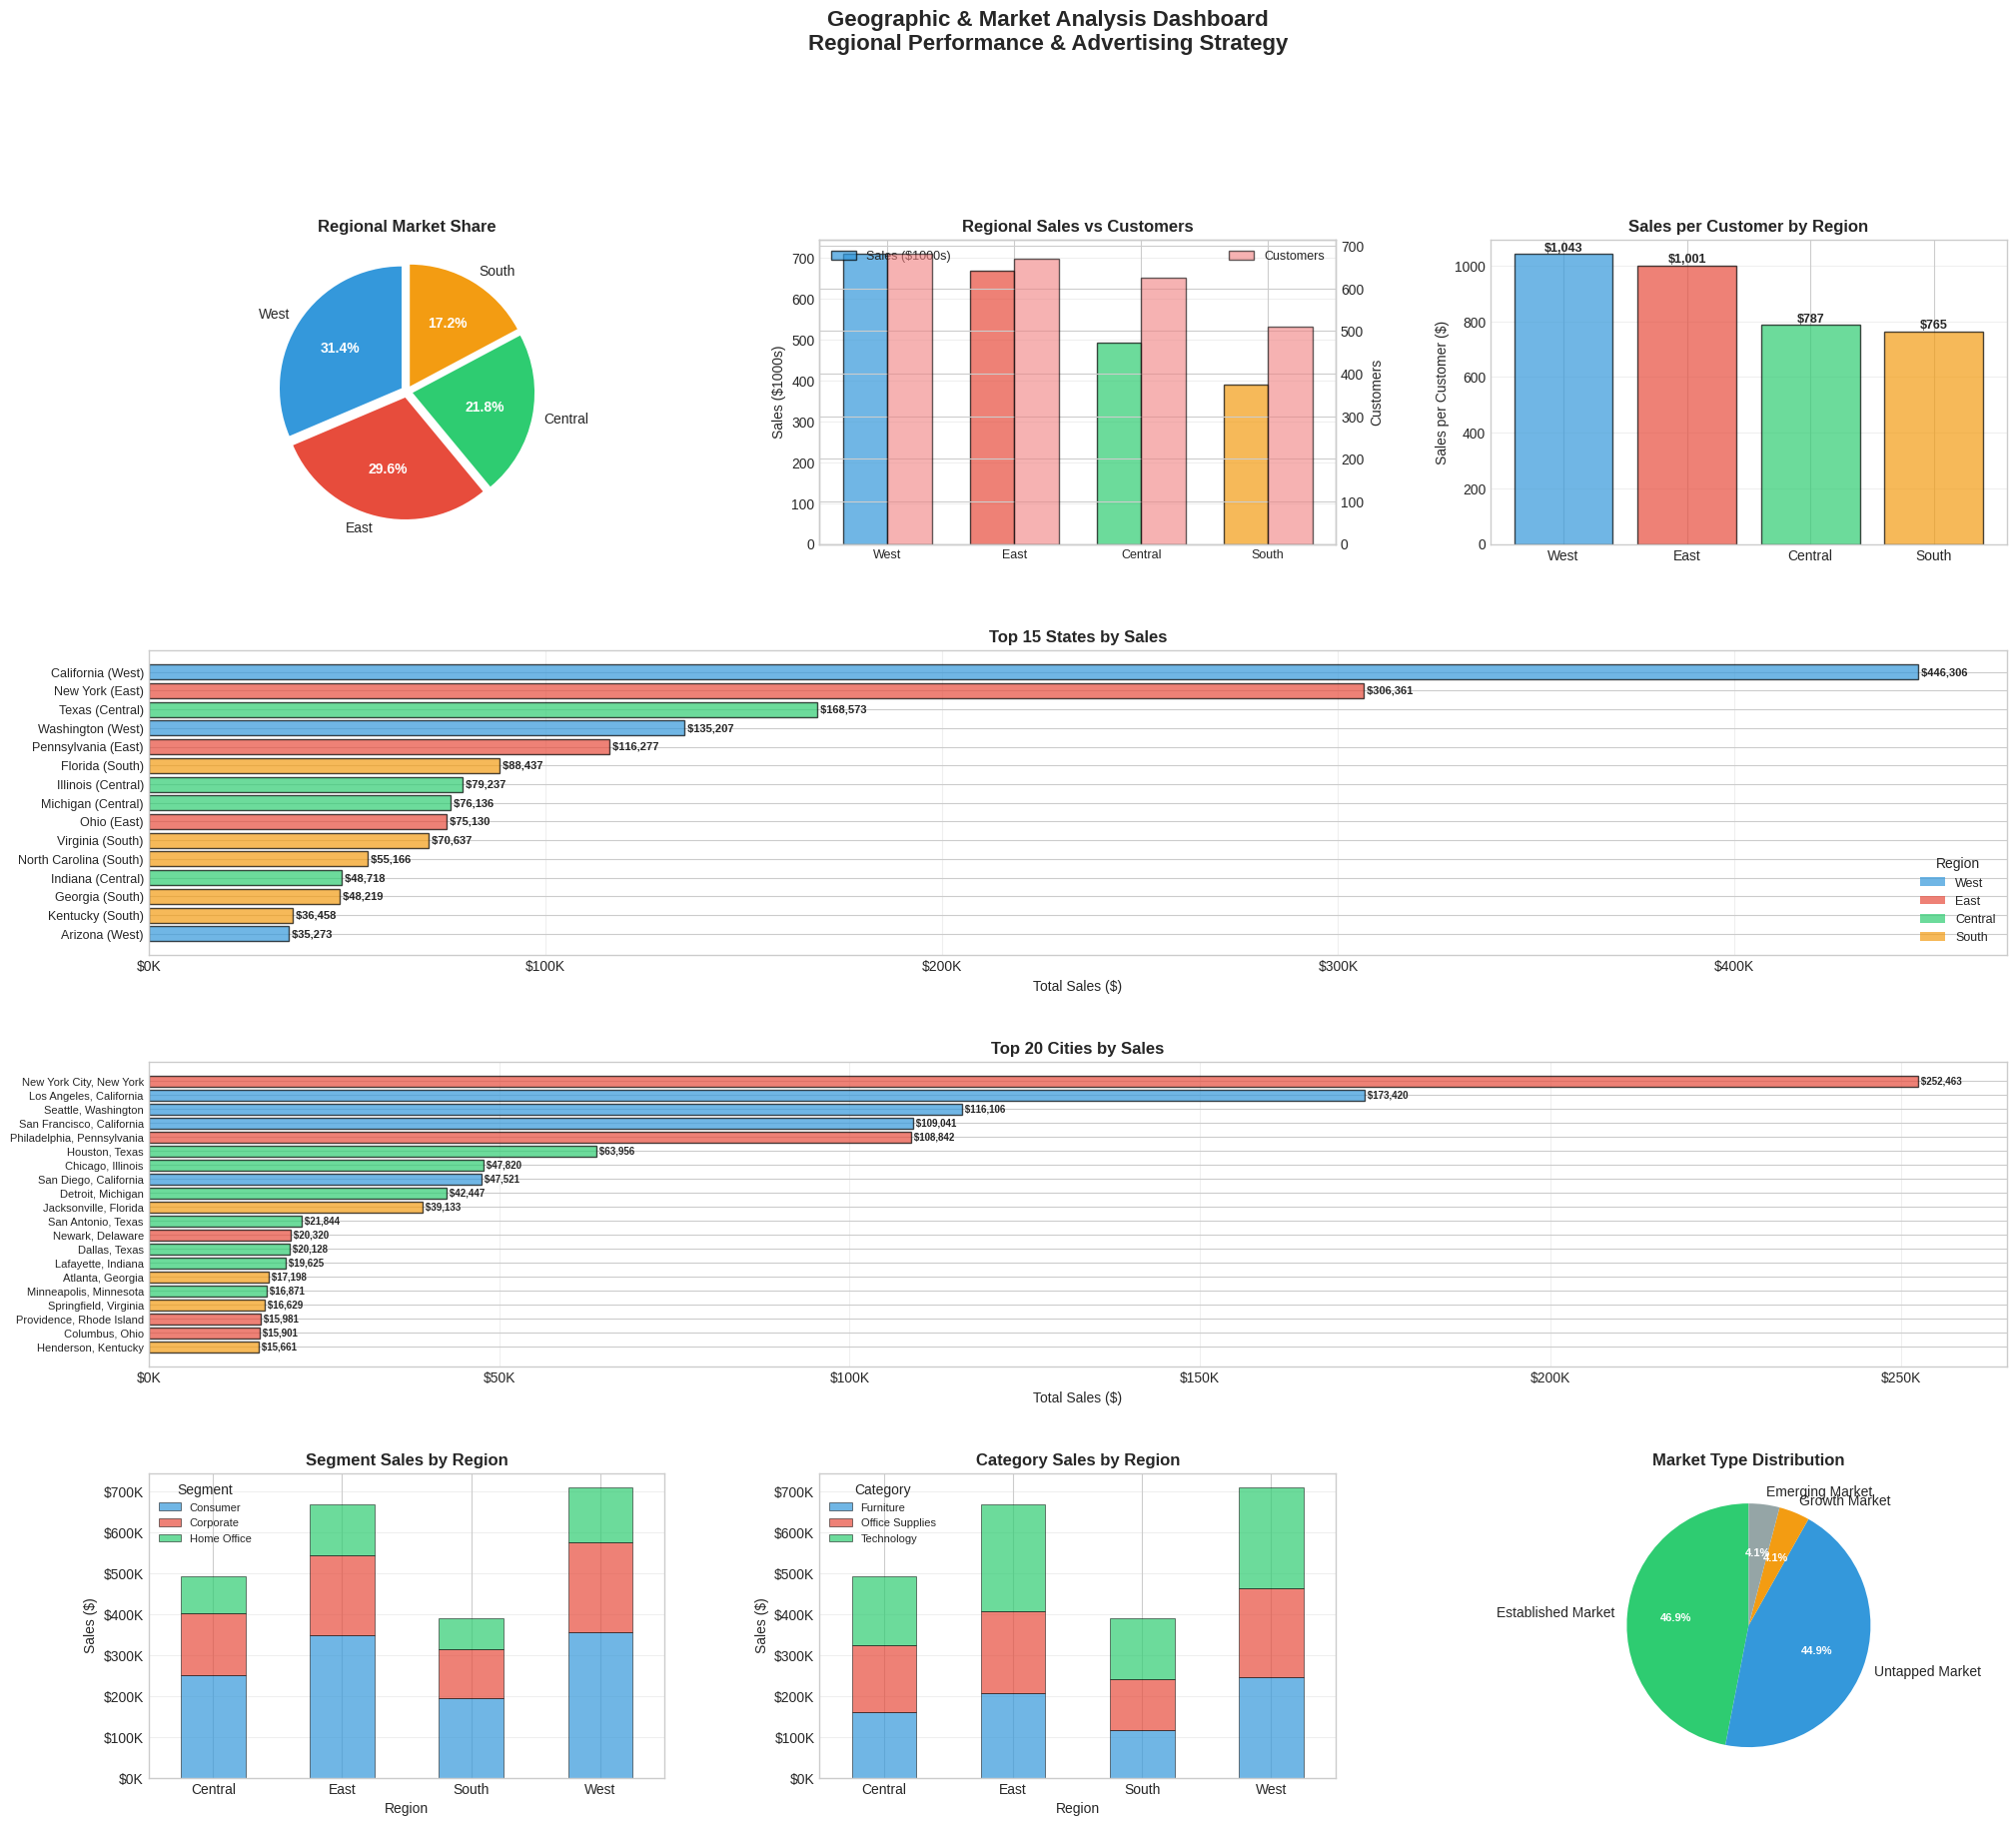

In [21]:
# =================================================================================
# SECTION 5: GEOGRAPHIC & MARKET ANALYSIS
# Regional Performance, Market Penetration, and Advertising Target Recommendations
# =================================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

print("\n" + "="*80)
print("SECTION 5: GEOGRAPHIC & MARKET ANALYSIS")
print("Regional Performance & Advertising Target Recommendations")
print("="*80)

# =================================================================================
# STEP 1: REGIONAL PERFORMANCE ANALYSIS
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 1: Regional Performance Analysis")
print(f"{'-'*80}")

# Aggregate by Region
region_perf = df.groupby('Region').agg({
    'Sales': ['sum', 'mean', 'count'],
    'Order ID': 'nunique',
    'Customer ID': 'nunique',
    'Product ID': 'nunique'
}).reset_index()

region_perf.columns = ['Region', 'Total_Sales', 'Avg_Order_Value', 'Total_Transactions',
                        'Unique_Orders', 'Unique_Customers', 'Unique_Products']

# Calculate metrics
total_sales = region_perf['Total_Sales'].sum()
region_perf['Market_Share_%'] = (region_perf['Total_Sales'] / total_sales) * 100
region_perf['Sales_Per_Customer'] = region_perf['Total_Sales'] / region_perf['Unique_Customers']
region_perf = region_perf.sort_values('Total_Sales', ascending=False)

print("\nRegional Performance Summary:")
print(region_perf[['Region', 'Total_Sales', 'Market_Share_%', 'Unique_Customers',
                   'Sales_Per_Customer']].to_string(index=False))

print(f"\nKey Regional Insights:")
for idx, row in region_perf.iterrows():
    print(f"  {row['Region']}:")
    print(f"    - Market Share: {row['Market_Share_%']:.2f}%")
    print(f"    - Customers: {int(row['Unique_Customers'])}")
    print(f"    - Avg Sales/Customer: ${row['Sales_Per_Customer']:,.2f}")

# =================================================================================
# STEP 2: STATE-LEVEL PERFORMANCE ANALYSIS
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 2: State-Level Performance Analysis")
print(f"{'-'*80}")

state_perf = df.groupby(['Region', 'State']).agg({
    'Sales': ['sum', 'mean', 'count'],
    'Customer ID': 'nunique',
    'Product ID': 'nunique'
}).reset_index()

state_perf.columns = ['Region', 'State', 'Total_Sales', 'Avg_Transaction',
                       'Total_Transactions', 'Unique_Customers', 'Unique_Products']

state_perf['Sales_Per_Customer'] = state_perf['Total_Sales'] / state_perf['Unique_Customers']
state_perf = state_perf.sort_values('Total_Sales', ascending=False)

print("\nTop 15 States by Sales:")
print(state_perf.head(15)[['State', 'Region', 'Total_Sales', 'Unique_Customers',
                            'Sales_Per_Customer']].to_string(index=False))

print("\nBottom 10 States by Sales:")
print(state_perf.tail(10)[['State', 'Region', 'Total_Sales', 'Unique_Customers',
                            'Sales_Per_Customer']].to_string(index=False))

# =================================================================================
# STEP 3: CITY-LEVEL PERFORMANCE ANALYSIS
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 3: City-Level Performance Analysis")
print(f"{'-'*80}")

city_perf = df.groupby(['Region', 'State', 'City']).agg({
    'Sales': ['sum', 'mean', 'count'],
    'Customer ID': 'nunique'
}).reset_index()

city_perf.columns = ['Region', 'State', 'City', 'Total_Sales', 'Avg_Transaction',
                      'Total_Transactions', 'Unique_Customers']

city_perf['Sales_Per_Customer'] = city_perf['Total_Sales'] / city_perf['Unique_Customers']
city_perf = city_perf.sort_values('Total_Sales', ascending=False)

print("\nTop 20 Cities by Sales:")
print(city_perf.head(20)[['City', 'State', 'Region', 'Total_Sales',
                           'Unique_Customers', 'Sales_Per_Customer']].to_string(index=False))

# =================================================================================
# STEP 4: SEGMENT PERFORMANCE BY REGION
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 4: Customer Segment Performance by Region")
print(f"{'-'*80}")

region_segment_perf = df.groupby(['Region', 'Segment']).agg({
    'Sales': 'sum',
    'Customer ID': 'nunique',
    'Order ID': 'count'
}).reset_index()

region_segment_perf.columns = ['Region', 'Segment', 'Total_Sales',
                                 'Unique_Customers', 'Total_Orders']

region_segment_pivot = region_segment_perf.pivot(index='Region',
                                                   columns='Segment',
                                                   values='Total_Sales').fillna(0)

print("\nSales by Region and Customer Segment:")
print(region_segment_pivot.to_string())

print("\nDominant Customer Segment by Region:")
for region in region_segment_pivot.index:
    dominant_segment = region_segment_pivot.loc[region].idxmax()
    dominant_value = region_segment_pivot.loc[region].max()
    total_regional_sales = region_segment_pivot.loc[region].sum()
    dominance_pct = (dominant_value / total_regional_sales) * 100
    print(f"  {region}: {dominant_segment} (${dominant_value:,.2f} - {dominance_pct:.1f}%)")

# =================================================================================
# STEP 5: CATEGORY PERFORMANCE BY REGION
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 5: Product Category Performance by Region")
print(f"{'-'*80}")

region_category_perf = df.groupby(['Region', 'Category']).agg({
    'Sales': 'sum',
    'Order ID': 'count'
}).reset_index()

region_category_perf.columns = ['Region', 'Category', 'Total_Sales', 'Total_Orders']

region_category_pivot = region_category_perf.pivot(index='Region',
                                                     columns='Category',
                                                     values='Total_Sales').fillna(0)

print("\nCategory Sales by Region:")
print(region_category_pivot.to_string())

print("\nTop 5 Sub-Categories by Region:")
for region in df['Region'].unique():
    region_data = df[df['Region'] == region]
    top_subcat = region_data.groupby('Sub-Category')['Sales'].sum().nlargest(5)
    print(f"\n  {region}:")
    for subcat, sales in top_subcat.items():
        print(f"    - {subcat}: ${sales:,.2f}")

# =================================================================================
# STEP 6: SUB-CATEGORY BY SEGMENT
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 6: Sub-Category Performance by Customer Segment")
print(f"{'-'*80}")

print("\nTop 5 Sub-Categories by Customer Segment:")
for segment in df['Segment'].unique():
    segment_data = df[df['Segment'] == segment]
    top_subcat = segment_data.groupby('Sub-Category')['Sales'].sum().nlargest(5)
    print(f"\n  {segment}:")
    for subcat, sales in top_subcat.items():
        print(f"    - {subcat}: ${sales:,.2f}")

# =================================================================================
# STEP 7: MARKET OPPORTUNITY CLASSIFICATION
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 7: Market Opportunity Analysis")
print(f"{'-'*80}")

median_sales = state_perf['Total_Sales'].median()
median_customers = state_perf['Unique_Customers'].median()

def classify_market_type(row):
    if row['Total_Sales'] >= median_sales and row['Unique_Customers'] >= median_customers:
        return 'Established Market'
    elif row['Total_Sales'] >= median_sales and row['Unique_Customers'] < median_customers:
        return 'Growth Market'
    elif row['Total_Sales'] < median_sales and row['Unique_Customers'] >= median_customers:
        return 'Emerging Market'
    else:
        return 'Untapped Market'

state_perf['Market_Type'] = state_perf.apply(classify_market_type, axis=1)

market_summary = state_perf.groupby('Market_Type').agg({
    'State': 'count',
    'Total_Sales': 'sum',
    'Unique_Customers': 'sum',
    'Sales_Per_Customer': 'mean'
}).round(2)

market_summary.columns = ['State_Count', 'Total_Sales', 'Total_Customers', 'Avg_Sales_Per_Customer']

print("\nMarket Type Summary:")
print(market_summary)

print("\nStates by Market Type:")
for market_type in ['Established Market', 'Growth Market', 'Emerging Market', 'Untapped Market']:
    states = state_perf[state_perf['Market_Type'] == market_type]['State'].tolist()
    print(f"\n  {market_type} ({len(states)} states):")
    print(f"    {', '.join(states[:10])}")
    if len(states) > 10:
        print(f"    ... and {len(states)-10} more")

# =================================================================================
# STEP 8: ADVERTISING STRATEGY
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 8: Advertising Target Recommendations")
print(f"{'-'*80}")

def get_ad_strategy(row):
    market_type = row['Market_Type']
    sales_per_customer = row['Sales_Per_Customer']

    if market_type == 'Established Market':
        return {
            'priority': 'High',
            'strategy': 'Retention & Upsell',
            'budget_%': 30,
            'channels': 'Email, Loyalty Programs, Retargeting',
            'message': 'Premium products, VIP benefits',
            'discount': '5-10%'
        }
    elif market_type == 'Growth Market':
        return {
            'priority': 'Very High',
            'strategy': 'Aggressive Acquisition',
            'budget_%': 35,
            'channels': 'Social Media, Google Ads, Influencer',
            'message': 'New customer discounts, referrals',
            'discount': '15-20%'
        }
    elif market_type == 'Emerging Market':
        return {
            'priority': 'High',
            'strategy': 'Basket Size Increase',
            'budget_%': 25,
            'channels': 'Email, Cross-sell Campaigns',
            'message': 'Bundle deals, upsell',
            'discount': '10-15%'
        }
    else:
        return {
            'priority': 'Low',
            'strategy': 'Market Testing',
            'budget_%': 10,
            'channels': 'Low-cost Digital',
            'message': 'Brand awareness',
            'discount': '20-25%'
        }

ad_data = state_perf.apply(get_ad_strategy, axis=1)

state_perf['Ad_Priority'] = ad_data.apply(lambda x: x['priority'])
state_perf['Ad_Strategy'] = ad_data.apply(lambda x: x['strategy'])
state_perf['Budget_%'] = ad_data.apply(lambda x: x['budget_%'])
state_perf['Channels'] = ad_data.apply(lambda x: x['channels'])
state_perf['Message'] = ad_data.apply(lambda x: x['message'])
state_perf['Discount'] = ad_data.apply(lambda x: x['discount'])

print("\nAdvertising Strategy by State (Top 20):")
print(state_perf.nlargest(20, 'Total_Sales')[
    ['State', 'Region', 'Market_Type', 'Ad_Priority', 'Ad_Strategy', 'Budget_%', 'Discount']
].to_string(index=False))

# =================================================================================
# STEP 9: REGIONAL CAMPAIGN PLAYBOOK
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 9: Regional Campaign Recommendations")
print(f"{'-'*80}")

print("\nREGIONAL TARGETING PLAYBOOK:")
print(f"{'='*80}")

for region in df['Region'].unique():
    print(f"\n{region.upper()} REGION:")
    region_data = df[df['Region'] == region]
    region_info = region_perf[region_perf['Region'] == region].iloc[0]

    dominant_segment = region_data.groupby('Segment')['Sales'].sum().idxmax()
    top_categories = region_data.groupby('Category')['Sales'].sum().nlargest(2)
    top_subcats = region_data.groupby('Sub-Category')['Sales'].sum().nlargest(3)
    top_cities = region_data.groupby('City')['Sales'].sum().nlargest(3)

    print(f"  Market Share: {region_info['Market_Share_%']:.2f}%")
    print(f"  Dominant Segment: {dominant_segment}")
    print(f"  Top Categories: {', '.join(top_categories.index.tolist())}")
    print(f"  Top Sub-Categories: {', '.join(top_subcats.index.tolist())}")
    print(f"  Top Cities: {', '.join(top_cities.index.tolist())}")
    print(f"\n  CAMPAIGN RECOMMENDATION:")
    print(f"    Target: {dominant_segment} customers")
    print(f"    Products: {top_subcats.index[0]}, {top_subcats.index[1]}")
    print(f"    Cities: {top_cities.index[0]}, {top_cities.index[1]}")

# =================================================================================
# STEP 10: VISUALIZATIONS
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 10: Creating Visualizations")
print(f"{'-'*80}")

plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(24, 20))
gs = GridSpec(4, 3, figure=fig, hspace=0.35, wspace=0.3)

region_colors = {'West': '#3498db', 'East': '#e74c3c',
                 'Central': '#2ecc71', 'South': '#f39c12'}

# Chart 1: Regional Market Share
ax1 = fig.add_subplot(gs[0, 0])
colors = [region_colors.get(r, '#95a5a6') for r in region_perf['Region']]
wedges, texts, autotexts = ax1.pie(region_perf['Total_Sales'], labels=region_perf['Region'],
                                     autopct='%1.1f%%', colors=colors, startangle=90,
                                     explode=[0.05]*len(region_perf))
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_weight('bold')
ax1.set_title('Regional Market Share', fontsize=12, fontweight='bold')
print("  ✓ Chart 1: Regional Market Share")

# Chart 2: Regional Sales vs Customers
ax2 = fig.add_subplot(gs[0, 1])
x = np.arange(len(region_perf))
width = 0.35
colors_list = [region_colors.get(r, '#95a5a6') for r in region_perf['Region']]
bars1 = ax2.bar(x - width/2, region_perf['Total_Sales']/1000, width,
                label='Sales ($1000s)', color=colors_list, alpha=0.7, edgecolor='black')
ax2_twin = ax2.twinx()
bars2 = ax2_twin.bar(x + width/2, region_perf['Unique_Customers'], width,
                     label='Customers', color='lightcoral', alpha=0.6, edgecolor='black')
ax2.set_xticks(x)
ax2.set_xticklabels(region_perf['Region'], fontsize=9)
ax2.set_title('Regional Sales vs Customers', fontsize=12, fontweight='bold')
ax2.set_ylabel('Sales ($1000s)', fontsize=10)
ax2_twin.set_ylabel('Customers', fontsize=10)
ax2.legend(loc='upper left', fontsize=9)
ax2_twin.legend(loc='upper right', fontsize=9)
ax2.grid(axis='y', alpha=0.3)
print("  ✓ Chart 2: Sales vs Customers")

# Chart 3: Sales per Customer by Region
ax3 = fig.add_subplot(gs[0, 2])
bars = ax3.bar(region_perf['Region'], region_perf['Sales_Per_Customer'],
               color=colors_list, alpha=0.7, edgecolor='black')
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax3.set_title('Sales per Customer by Region', fontsize=12, fontweight='bold')
ax3.set_ylabel('Sales per Customer ($)', fontsize=10)
ax3.grid(axis='y', alpha=0.3)
print("  ✓ Chart 3: Sales per Customer")

# Chart 4: Top 15 States
ax4 = fig.add_subplot(gs[1, :])
top_states = state_perf.nlargest(15, 'Total_Sales').sort_values('Total_Sales')
state_colors_map = dict(zip(region_perf['Region'], colors_list))
bar_colors = [state_colors_map.get(r, '#95a5a6') for r in top_states['Region']]
bars = ax4.barh(range(len(top_states)), top_states['Total_Sales'],
                color=bar_colors, alpha=0.7, edgecolor='black')
ax4.set_yticks(range(len(top_states)))
ax4.set_yticklabels([f"{row['State']} ({row['Region']})"
                      for _, row in top_states.iterrows()], fontsize=9)
for i, (idx, row) in enumerate(top_states.iterrows()):
    ax4.text(row['Total_Sales'], i, f" ${row['Total_Sales']:,.0f}",
            va='center', fontsize=8, fontweight='bold')
ax4.set_title('Top 15 States by Sales', fontsize=12, fontweight='bold')
ax4.set_xlabel('Total Sales ($)', fontsize=10)
ax4.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax4.grid(axis='x', alpha=0.3)
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=region_colors[reg], label=reg, alpha=0.7)
                   for reg in region_colors.keys()]
ax4.legend(handles=legend_elements, loc='lower right', fontsize=9, title='Region')
print("  ✓ Chart 4: Top States")

# Chart 5: Top 20 Cities
ax5 = fig.add_subplot(gs[2, :])
top_cities = city_perf.nlargest(20, 'Total_Sales').sort_values('Total_Sales')
bar_colors = [state_colors_map.get(r, '#95a5a6') for r in top_cities['Region']]
bars = ax5.barh(range(len(top_cities)), top_cities['Total_Sales'],
                color=bar_colors, alpha=0.7, edgecolor='black')
ax5.set_yticks(range(len(top_cities)))
ax5.set_yticklabels([f"{row['City']}, {row['State']}"
                      for _, row in top_cities.iterrows()], fontsize=8)
for i, (idx, row) in enumerate(top_cities.iterrows()):
    ax5.text(row['Total_Sales'], i, f" ${row['Total_Sales']:,.0f}",
            va='center', fontsize=7, fontweight='bold')
ax5.set_title('Top 20 Cities by Sales', fontsize=12, fontweight='bold')
ax5.set_xlabel('Total Sales ($)', fontsize=10)
ax5.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax5.grid(axis='x', alpha=0.3)
print("  ✓ Chart 5: Top Cities")

# Chart 6: Segment by Region
ax6 = fig.add_subplot(gs[3, 0])
region_segment_pivot.plot(kind='bar', stacked=True, ax=ax6,
                          color=['#3498db', '#e74c3c', '#2ecc71'],
                          alpha=0.7, edgecolor='black', linewidth=0.5)
ax6.set_title('Segment Sales by Region', fontsize=12, fontweight='bold')
ax6.set_xlabel('Region', fontsize=10)
ax6.set_ylabel('Sales ($)', fontsize=10)
ax6.legend(title='Segment', fontsize=8, loc='upper left')
ax6.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=0)
ax6.grid(axis='y', alpha=0.3)
print("  ✓ Chart 6: Segment by Region")

# Chart 7: Category by Region
ax7 = fig.add_subplot(gs[3, 1])
region_category_pivot.plot(kind='bar', stacked=True, ax=ax7,
                            color=['#3498db', '#e74c3c', '#2ecc71'],
                            alpha=0.7, edgecolor='black', linewidth=0.5)
ax7.set_title('Category Sales by Region', fontsize=12, fontweight='bold')
ax7.set_xlabel('Region', fontsize=10)
ax7.set_ylabel('Sales ($)', fontsize=10)
ax7.legend(title='Category', fontsize=8, loc='upper left')
ax7.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax7.set_xticklabels(ax7.get_xticklabels(), rotation=0)
ax7.grid(axis='y', alpha=0.3)
print("  ✓ Chart 7: Category by Region")

# Chart 8: Market Type Distribution
ax8 = fig.add_subplot(gs[3, 2])
market_counts = state_perf['Market_Type'].value_counts()
market_colors = ['#2ecc71', '#3498db', '#f39c12', '#95a5a6']
wedges, texts, autotexts = ax8.pie(market_counts.values, labels=market_counts.index,
                                     autopct='%1.1f%%', colors=market_colors, startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(8)
    autotext.set_weight('bold')
ax8.set_title('Market Type Distribution', fontsize=12, fontweight='bold')
print("  ✓ Chart 8: Market Types")

fig.suptitle('Geographic & Market Analysis Dashboard\nRegional Performance & Advertising Strategy',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('geographic_market_analysis.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Saved: geographic_market_analysis.png")
plt.show()


SECTION 6: CUSTOMER CLUSTERING & PACKAGE BUNDLING ANALYSIS
Promotional Package Recommendations by Customer Behavior

--------------------------------------------------------------------------------
STEP 1: Customer Behavioral Data Preparation
--------------------------------------------------------------------------------

✓ Customer behavioral data prepared for 793 customers

Behavioral Metrics Summary:
  Order Frequency: 12.4 avg orders
  Avg Transaction Value: $227.41
  Customer Tenure: 993 days avg

--------------------------------------------------------------------------------
STEP 2: Shipping Mode Analysis
--------------------------------------------------------------------------------

Shipping Mode Performance by Segment:
Segment            Consumer    Corporate  Home Office
Ship_Mode                                            
First Class     158104.9470  102580.0539   84887.2564
Same Day         57452.2730   45121.3230   22645.4430
Second Class    230125.5356  139045.2908  

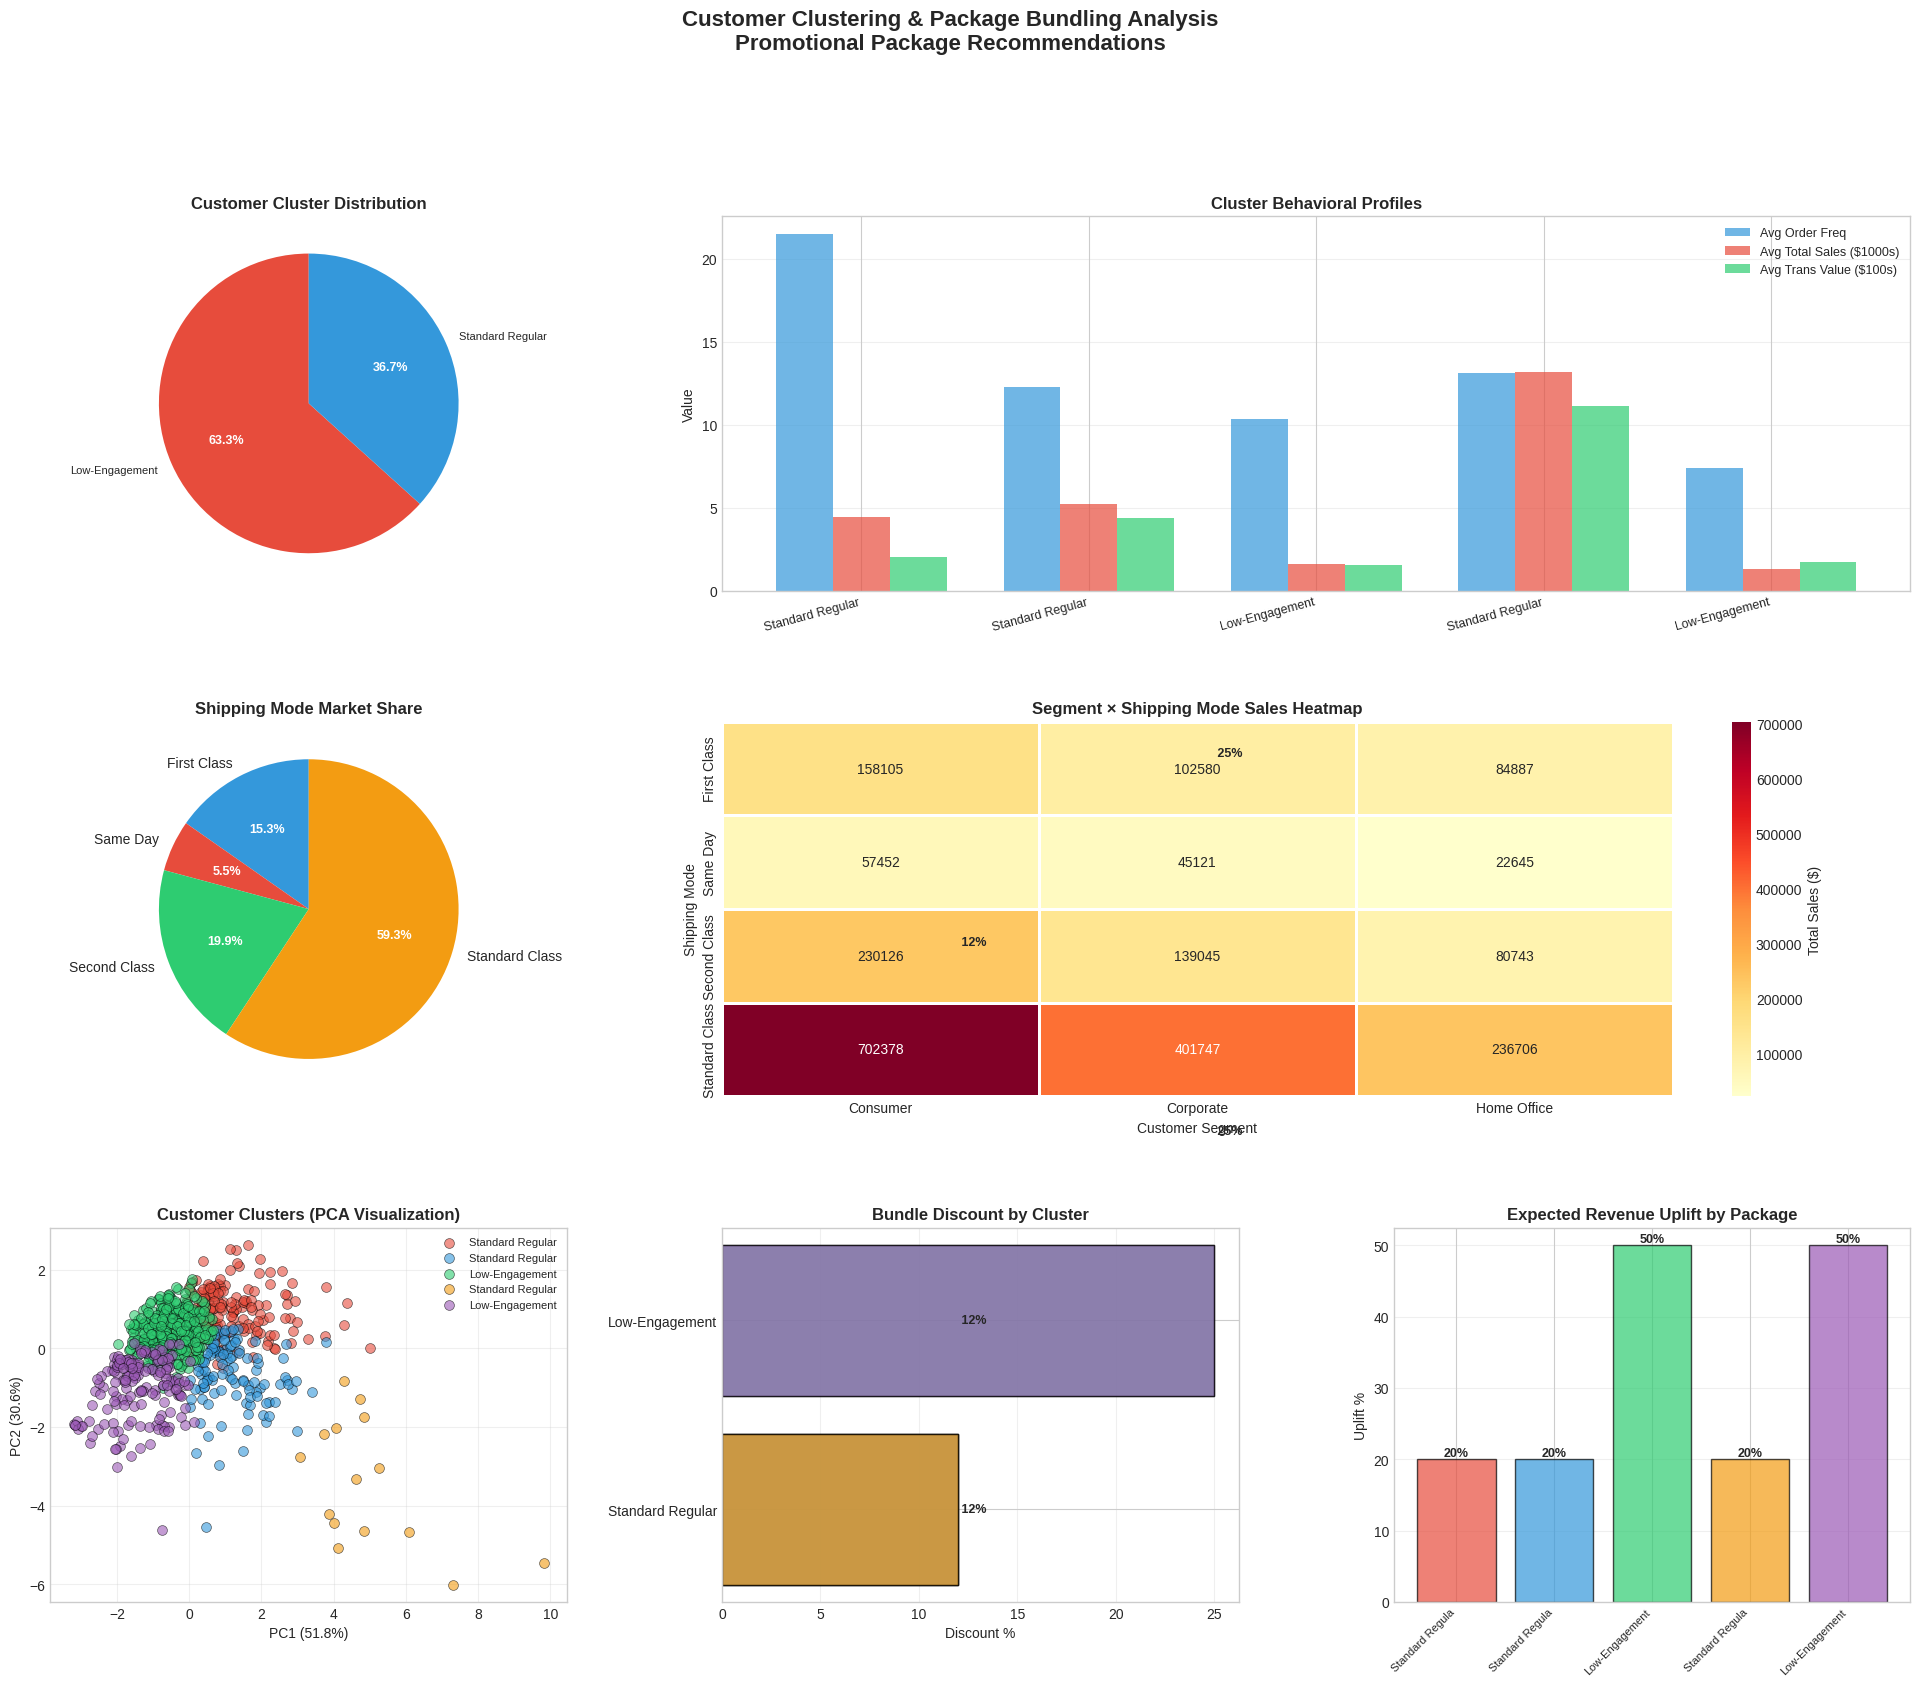


✓ SECTION 6: CUSTOMER CLUSTERING & PACKAGE BUNDLING COMPLETE


In [22]:
# =================================================================================
# SECTION 6: CUSTOMER CLUSTERING & PACKAGE BUNDLING ANALYSIS
# Segment × Shipping Mode × Order Frequency × Transaction Value Analysis
# =================================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print("\n" + "="*80)
print("SECTION 6: CUSTOMER CLUSTERING & PACKAGE BUNDLING ANALYSIS")
print("Promotional Package Recommendations by Customer Behavior")
print("="*80)

# =================================================================================
# STEP 1: CUSTOMER BEHAVIORAL DATA PREPARATION
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 1: Customer Behavioral Data Preparation")
print(f"{'-'*80}")

# Aggregate customer behavior metrics
customer_behavior = df.groupby('Customer ID').agg({
    'Order ID': 'count',                    # Order Frequency
    'Sales': ['sum', 'mean'],               # Transaction Value
    'Ship Mode': lambda x: x.mode()[0],     # Preferred Shipping Mode
    'Segment': 'first',                     # Customer Segment
    'Customer Name': 'first',
    'Category': lambda x: x.mode()[0],      # Most Purchased Category
    'Sub-Category': lambda x: x.mode()[0],  # Most Purchased Sub-Category
    'Order Date': lambda x: (x.max() - x.min()).days  # Customer Tenure
}).reset_index()

customer_behavior.columns = ['Customer_ID', 'Order_Frequency', 'Total_Sales',
                              'Avg_Transaction_Value', 'Preferred_Ship_Mode',
                              'Segment', 'Customer_Name', 'Top_Category',
                              'Top_SubCategory', 'Tenure_Days']

print(f"\n✓ Customer behavioral data prepared for {len(customer_behavior)} customers")
print(f"\nBehavioral Metrics Summary:")
print(f"  Order Frequency: {customer_behavior['Order_Frequency'].mean():.1f} avg orders")
print(f"  Avg Transaction Value: ${customer_behavior['Avg_Transaction_Value'].mean():,.2f}")
print(f"  Customer Tenure: {customer_behavior['Tenure_Days'].mean():.0f} days avg")

# =================================================================================
# STEP 2: SHIPPING MODE ANALYSIS
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 2: Shipping Mode Analysis")
print(f"{'-'*80}")

shipping_analysis = df.groupby(['Ship Mode', 'Segment']).agg({
    'Sales': ['sum', 'mean', 'count'],
    'Customer ID': 'nunique'
}).reset_index()

shipping_analysis.columns = ['Ship_Mode', 'Segment', 'Total_Sales',
                              'Avg_Order_Value', 'Total_Orders', 'Unique_Customers']

shipping_analysis['Orders_Per_Customer'] = (shipping_analysis['Total_Orders'] /
                                             shipping_analysis['Unique_Customers'])

print("\nShipping Mode Performance by Segment:")
shipping_pivot = shipping_analysis.pivot_table(
    index='Ship_Mode',
    columns='Segment',
    values='Total_Sales',
    fill_value=0
)
print(shipping_pivot.to_string())

# Overall shipping mode preference
ship_mode_summary = df.groupby('Ship Mode').agg({
    'Sales': ['sum', 'count'],
    'Customer ID': 'nunique'
}).reset_index()

ship_mode_summary.columns = ['Ship_Mode', 'Total_Sales', 'Total_Orders', 'Unique_Customers']
ship_mode_summary['Market_Share_%'] = (ship_mode_summary['Total_Sales'] /
                                        ship_mode_summary['Total_Sales'].sum()) * 100

print("\nShipping Mode Market Share:")
print(ship_mode_summary[['Ship_Mode', 'Total_Sales', 'Total_Orders', 'Market_Share_%']].to_string(index=False))

# =================================================================================
# STEP 3: SEGMENT × SHIPPING MODE × CATEGORY ANALYSIS
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 3: Segment × Shipping Mode × Category Cross-Analysis")
print(f"{'-'*80}")

# Three-way analysis
cross_analysis = df.groupby(['Segment', 'Ship Mode', 'Category']).agg({
    'Sales': ['sum', 'count', 'mean'],
    'Customer ID': 'nunique'
}).reset_index()

cross_analysis.columns = ['Segment', 'Ship_Mode', 'Category', 'Total_Sales',
                          'Order_Count', 'Avg_Order_Value', 'Unique_Customers']

cross_analysis = cross_analysis.sort_values('Total_Sales', ascending=False)

print("\nTop 20 Segment-Shipping-Category Combinations:")
print(cross_analysis.head(20)[['Segment', 'Ship_Mode', 'Category', 'Total_Sales',
                                'Order_Count', 'Avg_Order_Value']].to_string(index=False))

# =================================================================================
# STEP 4: CUSTOMER CLUSTERING BASED ON BEHAVIOR
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 4: K-Means Clustering on Customer Behavior")
print(f"{'-'*80}")

# Prepare features for clustering
clustering_features = customer_behavior[['Order_Frequency', 'Total_Sales',
                                          'Avg_Transaction_Value', 'Tenure_Days']].copy()

# Handle missing values
clustering_features = clustering_features.fillna(0)

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(clustering_features)

# Determine optimal number of clusters using elbow method
inertias = []
K_range = range(3, 9)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)

# Use 5 clusters for detailed segmentation
optimal_k = 5
print(f"\n✓ Using {optimal_k} clusters for customer segmentation")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_behavior['Cluster'] = kmeans_final.fit_predict(features_scaled)

# Analyze cluster characteristics
cluster_profile = customer_behavior.groupby('Cluster').agg({
    'Customer_ID': 'count',
    'Order_Frequency': 'mean',
    'Total_Sales': 'mean',
    'Avg_Transaction_Value': 'mean',
    'Tenure_Days': 'mean'
}).round(2)

cluster_profile.columns = ['Customer_Count', 'Avg_Order_Freq', 'Avg_Total_Sales',
                            'Avg_Transaction_Value', 'Avg_Tenure_Days']

print("\nCluster Profiles:")
print(cluster_profile)

# Name clusters based on characteristics
def name_cluster(row):
    """Assign meaningful names to clusters based on behavior"""
    cluster_id = row.name
    order_freq = cluster_profile.loc[cluster_id, 'Avg_Order_Freq']
    total_sales = cluster_profile.loc[cluster_id, 'Avg_Total_Sales']
    avg_trans = cluster_profile.loc[cluster_id, 'Avg_Transaction_Value']

    # High frequency, high value
    if order_freq > cluster_profile['Avg_Order_Freq'].quantile(0.75) and \
       total_sales > cluster_profile['Avg_Total_Sales'].quantile(0.75):
        return 'Premium High-Frequency'

    # High value, low frequency
    elif total_sales > cluster_profile['Avg_Total_Sales'].quantile(0.75) and \
         order_freq < cluster_profile['Avg_Order_Freq'].median():
        return 'High-Value Occasional'

    # High frequency, low value
    elif order_freq > cluster_profile['Avg_Order_Freq'].quantile(0.75) and \
         avg_trans < cluster_profile['Avg_Transaction_Value'].median():
        return 'Frequent Small-Basket'

    # Medium all-around
    elif order_freq > cluster_profile['Avg_Order_Freq'].quantile(0.25) and \
         total_sales > cluster_profile['Avg_Total_Sales'].quantile(0.25):
        return 'Standard Regular'

    # Low engagement
    else:
        return 'Low-Engagement'

cluster_profile['Cluster_Name'] = cluster_profile.apply(name_cluster, axis=1)

# Map cluster names back to customer behavior
cluster_name_map = cluster_profile['Cluster_Name'].to_dict()
customer_behavior['Cluster_Name'] = customer_behavior['Cluster'].map(cluster_name_map)

print("\nNamed Cluster Profiles:")
print(cluster_profile)

# =================================================================================
# STEP 5: PACKAGE BUNDLING STRATEGY DEVELOPMENT
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 5: Package Bundling Strategy Development")
print(f"{'-'*80}")

# Analyze popular product combinations by cluster
print("\nTop Product Combinations by Cluster:")

for cluster_id in range(optimal_k):
    cluster_name = cluster_name_map[cluster_id]
    print(f"\n{cluster_name.upper()} (Cluster {cluster_id}):")

    # Get customers in this cluster
    cluster_customers = customer_behavior[customer_behavior['Cluster'] == cluster_id]['Customer_ID'].tolist()

    # Get their orders
    cluster_orders = df[df['Customer ID'].isin(cluster_customers)]

    # Top categories
    top_categories = cluster_orders.groupby('Category')['Sales'].sum().nlargest(3)
    print(f"  Top Categories: {', '.join(top_categories.index.tolist())}")

    # Top sub-categories
    top_subcats = cluster_orders.groupby('Sub-Category')['Sales'].sum().nlargest(5)
    print(f"  Top Sub-Categories:")
    for subcat, sales in top_subcats.items():
        print(f"    - {subcat}: ${sales:,.2f}")

    # Preferred shipping mode
    top_ship = cluster_orders.groupby('Ship Mode')['Order ID'].count().idxmax()
    ship_pct = (cluster_orders[cluster_orders['Ship Mode'] == top_ship].shape[0] /
                cluster_orders.shape[0]) * 100
    print(f"  Preferred Shipping: {top_ship} ({ship_pct:.1f}%)")

    # Dominant segment
    top_segment = cluster_orders.groupby('Segment')['Customer ID'].nunique().idxmax()
    print(f"  Dominant Segment: {top_segment}")

# =================================================================================
# STEP 6: PROMOTIONAL PACKAGE RECOMMENDATIONS
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 6: Promotional Package Recommendations")
print(f"{'-'*80}")

def create_package_recommendation(cluster_id, customer_behavior_df, df_original):
    """Create detailed package recommendations for each cluster"""

    cluster_name = cluster_name_map[cluster_id]
    cluster_customers = customer_behavior_df[customer_behavior_df['Cluster'] == cluster_id]['Customer_ID'].tolist()
    cluster_orders = df_original[df_original['Customer ID'].isin(cluster_customers)]

    # Cluster metrics
    cluster_metrics = cluster_profile.loc[cluster_id]

    # Top products
    top_subcats = cluster_orders.groupby('Sub-Category')['Sales'].sum().nlargest(5)
    top_categories = cluster_orders.groupby('Category')['Sales'].sum().nlargest(3)

    # Shipping preference
    ship_preference = cluster_orders.groupby('Ship Mode')['Order ID'].count()
    preferred_ship = ship_preference.idxmax()

    # Segment distribution
    segment_dist = cluster_orders.groupby('Segment')['Customer ID'].nunique()
    dominant_segment = segment_dist.idxmax()

    # Calculate package value
    avg_basket = cluster_metrics['Avg_Transaction_Value']

    # Determine discount and package structure
    if cluster_name == 'Premium High-Frequency':
        return {
            'cluster_name': cluster_name,
            'customer_count': cluster_metrics['Customer_Count'],
            'package_name': 'VIP Exclusive Bundle',
            'target_segment': dominant_segment,
            'shipping_mode': preferred_ship,
            'shipping_discount': 'Free Shipping',
            'product_bundle': f"{top_subcats.index[0]} + {top_subcats.index[1]} + {top_subcats.index[2]}",
            'bundle_discount_%': 10,
            'package_price': avg_basket * 2.5 * 0.90,  # 2.5x items with 10% discount
            'promo_frequency': 'Monthly',
            'value_proposition': 'Premium bundle for loyal customers with free express shipping',
            'expected_uplift_%': 25
        }

    elif cluster_name == 'High-Value Occasional':
        return {
            'cluster_name': cluster_name,
            'customer_count': cluster_metrics['Customer_Count'],
            'package_name': 'Premium Combo Deal',
            'target_segment': dominant_segment,
            'shipping_mode': preferred_ship,
            'shipping_discount': 'Free Standard Shipping on $200+',
            'product_bundle': f"{top_subcats.index[0]} + {top_subcats.index[1]}",
            'bundle_discount_%': 15,
            'package_price': avg_basket * 1.8 * 0.85,  # 1.8x items with 15% discount
            'promo_frequency': 'Quarterly',
            'value_proposition': 'High-value bundles to increase purchase frequency',
            'expected_uplift_%': 30
        }

    elif cluster_name == 'Frequent Small-Basket':
        return {
            'cluster_name': cluster_name,
            'customer_count': cluster_metrics['Customer_Count'],
            'package_name': 'Value Pack Special',
            'target_segment': dominant_segment,
            'shipping_mode': preferred_ship,
            'shipping_discount': '$5 Flat Rate Shipping',
            'product_bundle': f"{top_subcats.index[0]} (x3) + {top_subcats.index[1]} (x2)",
            'bundle_discount_%': 20,
            'package_price': avg_basket * 3 * 0.80,  # 3x items with 20% discount
            'promo_frequency': 'Weekly',
            'value_proposition': 'Bulk savings to increase basket size',
            'expected_uplift_%': 40
        }

    elif cluster_name == 'Standard Regular':
        return {
            'cluster_name': cluster_name,
            'customer_count': cluster_metrics['Customer_Count'],
            'package_name': 'Essential Bundle',
            'target_segment': dominant_segment,
            'shipping_mode': preferred_ship,
            'shipping_discount': 'Free Shipping on $100+',
            'product_bundle': f"{top_subcats.index[0]} + {top_subcats.index[1]} + Free Gift",
            'bundle_discount_%': 12,
            'package_price': avg_basket * 2 * 0.88,  # 2x items with 12% discount
            'promo_frequency': 'Bi-weekly',
            'value_proposition': 'Standard value bundles with free gift incentive',
            'expected_uplift_%': 20
        }

    else:  # Low-Engagement
        return {
            'cluster_name': cluster_name,
            'customer_count': cluster_metrics['Customer_Count'],
            'package_name': 'Starter Pack',
            'target_segment': dominant_segment,
            'shipping_mode': 'Standard Class',  # Cost-effective
            'shipping_discount': '$10 off shipping on first bundle',
            'product_bundle': f"{top_subcats.index[0]} + Trial Products",
            'bundle_discount_%': 25,
            'package_price': avg_basket * 1.5 * 0.75,  # 1.5x items with 25% discount
            'promo_frequency': 'One-time Activation',
            'value_proposition': 'Aggressive discount to re-engage dormant customers',
            'expected_uplift_%': 50
        }

# Generate package recommendations
package_recommendations = []

for cluster_id in range(optimal_k):
    recommendation = create_package_recommendation(cluster_id, customer_behavior, df)
    package_recommendations.append(recommendation)

# Convert to DataFrame
packages_df = pd.DataFrame(package_recommendations)

print("\n" + "="*80)
print("PROMOTIONAL PACKAGE RECOMMENDATIONS")
print("="*80)

for idx, package in packages_df.iterrows():
    print(f"\n{'─'*80}")
    print(f"PACKAGE {idx+1}: {package['package_name'].upper()}")
    print(f"{'─'*80}")
    print(f"Target Cluster: {package['cluster_name']}")
    print(f"Customer Base: {int(package['customer_count'])} customers")
    print(f"Target Segment: {package['target_segment']}")
    print(f"\nBUNDLE DETAILS:")
    print(f"  Products: {package['product_bundle']}")
    print(f"  Discount: {package['bundle_discount_%']}% off")
    print(f"  Package Price: ${package['package_price']:,.2f}")
    print(f"\nSHIPPING:")
    print(f"  Preferred Mode: {package['shipping_mode']}")
    print(f"  Shipping Offer: {package['shipping_discount']}")
    print(f"\nPROMOTION STRATEGY:")
    print(f"  Frequency: {package['promo_frequency']}")
    print(f"  Value Proposition: {package['value_proposition']}")
    print(f"  Expected Revenue Uplift: {package['expected_uplift_%']}%")

# =================================================================================
# STEP 7: DETAILED SEGMENT-SHIPPING PACKAGE MATRIX
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 7: Segment-Shipping Mode Package Matrix")
print(f"{'-'*80}")

# Create detailed combinations
segment_ship_packages = []

for segment in df['Segment'].unique():
    for ship_mode in df['Ship Mode'].unique():

        # Filter data
        subset = df[(df['Segment'] == segment) & (df['Ship Mode'] == ship_mode)]

        if len(subset) == 0:
            continue

        # Get top products
        top_products = subset.groupby('Sub-Category')['Sales'].sum().nlargest(3)

        # Calculate metrics
        total_sales = subset['Sales'].sum()
        order_count = subset['Order ID'].nunique()
        avg_order = total_sales / order_count if order_count > 0 else 0
        customer_count = subset['Customer ID'].nunique()

        # Determine package strategy
        if avg_order > subset['Sales'].mean():
            package_type = 'Premium Bundle'
            discount = 10
        elif order_count > df['Order ID'].nunique() * 0.1:
            package_type = 'Popular Pack'
            discount = 15
        else:
            package_type = 'Starter Set'
            discount = 20

        segment_ship_packages.append({
            'Segment': segment,
            'Ship_Mode': ship_mode,
            'Package_Type': package_type,
            'Top_Product_1': top_products.index[0] if len(top_products) > 0 else 'N/A',
            'Top_Product_2': top_products.index[1] if len(top_products) > 1 else 'N/A',
            'Top_Product_3': top_products.index[2] if len(top_products) > 2 else 'N/A',
            'Customer_Count': customer_count,
            'Total_Sales': total_sales,
            'Avg_Order_Value': avg_order,
            'Discount_%': discount,
            'Bundle_Price': avg_order * 2 * (1 - discount/100)
        })

segment_ship_df = pd.DataFrame(segment_ship_packages)
segment_ship_df = segment_ship_df.sort_values('Total_Sales', ascending=False)

print("\nTop 15 Segment-Shipping Combinations with Package Recommendations:")
print(segment_ship_df.head(15)[['Segment', 'Ship_Mode', 'Package_Type',
                                 'Top_Product_1', 'Top_Product_2',
                                 'Discount_%', 'Bundle_Price']].to_string(index=False))

# =================================================================================
# STEP 8: VISUALIZATIONS
# =================================================================================
print(f"\n{'-'*80}")
print("STEP 8: Creating Clustering & Package Visualizations")
print(f"{'-'*80}")

plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(24, 18))
gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.3)

cluster_colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

# Chart 1: Cluster Distribution
ax1 = fig.add_subplot(gs[0, 0])
cluster_counts = customer_behavior['Cluster_Name'].value_counts()
wedges, texts, autotexts = ax1.pie(cluster_counts.values, labels=cluster_counts.index,
                                     autopct='%1.1f%%', colors=cluster_colors,
                                     startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(9)
    autotext.set_weight('bold')
for text in texts:
    text.set_fontsize(8)
ax1.set_title('Customer Cluster Distribution', fontsize=12, fontweight='bold')
print("  ✓ Chart 1: Cluster Distribution")

# Chart 2: Cluster Profiles (Radar Chart alternative - Bar Chart)
ax2 = fig.add_subplot(gs[0, 1:])
cluster_profile_plot = cluster_profile[['Avg_Order_Freq', 'Avg_Total_Sales',
                                         'Avg_Transaction_Value']].copy()
cluster_profile_plot['Avg_Total_Sales'] = cluster_profile_plot['Avg_Total_Sales'] / 1000  # Scale

x = np.arange(len(cluster_profile_plot))
width = 0.25

bars1 = ax2.bar(x - width, cluster_profile_plot['Avg_Order_Freq'],
                width, label='Avg Order Freq', color='#3498db', alpha=0.7)
bars2 = ax2.bar(x, cluster_profile_plot['Avg_Total_Sales'],
                width, label='Avg Total Sales ($1000s)', color='#e74c3c', alpha=0.7)
bars3 = ax2.bar(x + width, cluster_profile_plot['Avg_Transaction_Value']/100,
                width, label='Avg Trans Value ($100s)', color='#2ecc71', alpha=0.7)

ax2.set_xticks(x)
ax2.set_xticklabels([cluster_name_map[i] for i in range(optimal_k)],
                     rotation=15, ha='right', fontsize=9)
ax2.set_title('Cluster Behavioral Profiles', fontsize=12, fontweight='bold')
ax2.set_ylabel('Value', fontsize=10)
ax2.legend(fontsize=9)
ax2.grid(axis='y', alpha=0.3)
print("  ✓ Chart 2: Cluster Profiles")

# Chart 3: Shipping Mode Distribution
ax3 = fig.add_subplot(gs[1, 0])
ship_colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
wedges, texts, autotexts = ax3.pie(ship_mode_summary['Total_Sales'],
                                     labels=ship_mode_summary['Ship_Mode'],
                                     autopct='%1.1f%%', colors=ship_colors,
                                     startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(9)
    autotext.set_weight('bold')
ax3.set_title('Shipping Mode Market Share', fontsize=12, fontweight='bold')
print("  ✓ Chart 3: Shipping Mode Distribution")

# Chart 4: Segment × Shipping Mode Heatmap
ax4 = fig.add_subplot(gs[1, 1:])
heatmap_data = shipping_analysis.pivot_table(index='Ship_Mode', columns='Segment',
                                               values='Total_Sales', fill_value=0)
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd',
            cbar_kws={'label': 'Total Sales ($)'}, linewidths=1,
            linecolor='white', ax=ax4)
ax4.set_title('Segment × Shipping Mode Sales Heatmap', fontsize=12, fontweight='bold')
ax4.set_xlabel('Customer Segment', fontsize=10)
ax4.set_ylabel('Shipping Mode', fontsize=10)
print("  ✓ Chart 4: Segment-Shipping Heatmap")

# Chart 5: PCA Visualization of Clusters
ax5 = fig.add_subplot(gs[2, 0])
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

for cluster_id in range(optimal_k):
    cluster_data = features_pca[customer_behavior['Cluster'] == cluster_id]
    ax5.scatter(cluster_data[:, 0], cluster_data[:, 1],
               c=cluster_colors[cluster_id], label=cluster_name_map[cluster_id],
               alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

ax5.set_title('Customer Clusters (PCA Visualization)', fontsize=12, fontweight='bold')
ax5.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10)
ax5.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10)
ax5.legend(fontsize=8, loc='best')
ax5.grid(True, alpha=0.3)
print("  ✓ Chart 5: PCA Cluster Visualization")

# Chart 6: Package Discount Strategy
ax6 = fig.add_subplot(gs[2, 1])
bars = ax6.barh(packages_df['cluster_name'], packages_df['bundle_discount_%'],
                color=cluster_colors, alpha=0.7, edgecolor='black')
for i, (idx, row) in enumerate(packages_df.iterrows()):
    ax6.text(row['bundle_discount_%'], i, f" {row['bundle_discount_%']}%",
            va='center', fontsize=9, fontweight='bold')
ax6.set_title('Bundle Discount by Cluster', fontsize=12, fontweight='bold')
ax6.set_xlabel('Discount %', fontsize=10)
ax6.grid(axis='x', alpha=0.3)
print("  ✓ Chart 6: Package Discounts")

# Chart 7: Expected Revenue Uplift
ax7 = fig.add_subplot(gs[2, 2])
bars = ax7.bar(range(len(packages_df)), packages_df['expected_uplift_%'],
               color=cluster_colors, alpha=0.7, edgecolor='black')
ax7.set_xticks(range(len(packages_df)))
ax7.set_xticklabels([name[:15] for name in packages_df['cluster_name']],
                     rotation=45, ha='right', fontsize=8)
for i, val in enumerate(packages_df['expected_uplift_%']):
    ax7.text(i, val, f'{val}%', ha='center', va='bottom',
            fontsize=9, fontweight='bold')
ax7.set_title('Expected Revenue Uplift by Package', fontsize=12, fontweight='bold')
ax7.set_ylabel('Uplift %', fontsize=10)
ax7.grid(axis='y', alpha=0.3)
print("  ✓ Chart 7: Revenue Uplift")

fig.suptitle('Customer Clustering & Package Bundling Analysis\nPromotional Package Recommendations',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('customer_clustering_package_analysis.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Saved: customer_clustering_package_analysis.png")
plt.show()


print(f"\n{'='*80}")
print("✓ SECTION 6: CUSTOMER CLUSTERING & PACKAGE BUNDLING COMPLETE")
print(f"{'='*80}")